# Crop Yield Prediction – Final Model Pipeline (Rev9)

## 1. Setup & Imports

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import shap

np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')
print("All libraries loaded.")

All libraries loaded.


## 2. Model Selection Menu

In [40]:
RUN_MODELS = {
    'LR': True,   # Baseline Linear Regression
    'RF': True,   # Random Forest
    'XGB': True,  # XGBoost
    'LSTM': True, # LSTM
    'CNN': True   # CNN
}

RUN_OPTUNA = True

## 3. Load & Preprocess Data (Corrected)

In [41]:
# Corrected Data Preprocessing
try:
    df = pd.read_csv("cleaned_crop_data.csv")
    print(f"Loaded initial data: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError("Ensure 'cleaned_crop_data.csv' is present. Run the EDA notebook first.")

TARGET = 'hg/ha_yield'
TIME_COL = 'Year'
CAT_COLS = ['Area', 'Item']
NUMERIC_COLS = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'fertilizer_kg/ha', 'solar_radiation_MJ/m2-day']
TARGET_DET = 'yield_detrended'

# 1. Split data chronologically
TRAIN_END = 2007
VAL_END = 2010
train_df_orig = df[df[TIME_COL] <= TRAIN_END].copy()
val_df_orig = df[(df[TIME_COL] > TRAIN_END) & (df[TIME_COL] <= VAL_END)].copy()
test_df_orig = df[df[TIME_COL] > VAL_END].copy()
print(f"1. Initial data split: Train: {train_df_orig.shape}, Val: {val_df_orig.shape}, Test: {test_df_orig.shape}")

# 2. Fit encoders ON TRAINING DATA ONLY
le_area = LabelEncoder().fit(train_df_orig['Area'])
le_item = LabelEncoder().fit(train_df_orig['Item'])
for d in [train_df_orig, val_df_orig, test_df_orig]:
    d['Area_Encoded'] = d['Area'].apply(lambda x: le_area.transform([x])[0] if x in le_area.classes_ else -1)
    d['Item_Encoded'] = d['Item'].apply(lambda x: le_item.transform([x])[0] if x in le_item.classes_ else -1)
print("2. Encoders fitted on train set and applied to all sets.")

# 3. Fit trend models ON TRAINING DATA ONLY
print("3. Fitting trend models on training data...")
trend_models = {}
for group, group_df in train_df_orig.groupby(CAT_COLS):
    trend_model = LinearRegression()
    trend_model.fit(group_df[[TIME_COL]], group_df[TARGET])
    trend_models[group] = trend_model

global_trend_model = LinearRegression().fit(train_df_orig[[TIME_COL]], train_df_orig[TARGET])
print(f"   Fitted {len(trend_models)} group-specific trend models and 1 global model.")

# 4. Apply detrending to all datasets
for df_set in [train_df_orig, val_df_orig, test_df_orig]:
    df_set['yield_trend'] = 0.0
    for group, group_df in df_set.groupby(CAT_COLS):
        model = trend_models.get(group, global_trend_model)
        trend_prediction = model.predict(group_df[[TIME_COL]])
        df_set.loc[group_df.index, 'yield_trend'] = trend_prediction
    df_set['yield_detrended'] = df_set[TARGET] - df_set['yield_trend']
print("   Detrending applied to all datasets.")

# 5. Create lags and finalize split for ML models
full_df_ml = pd.concat([train_df_orig, val_df_orig, test_df_orig]).sort_values(CAT_COLS + [TIME_COL])
lag_cols = ['yield_detrended'] + NUMERIC_COLS
for col in lag_cols:
    for lag in [1, 2]:
        full_df_ml[f'{col}_lag{lag}'] = full_df_ml.groupby(CAT_COLS)[col].shift(lag)

df_ml = full_df_ml.dropna().copy()
train_df = df_ml[df_ml[TIME_COL] <= TRAIN_END].copy()
val_df = df_ml[(df_ml[TIME_COL] > TRAIN_END) & (df_ml[TIME_COL] <= VAL_END)].copy()
test_df = df_ml[df_ml[TIME_COL] > VAL_END].copy()
print(f"4. Lags created for ML models: Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

# 6. Fit scalers for ML models ON TRAINING DATA ONLY
lagged_cols = [c for c in df_ml.columns if '_lag' in c]
ml_features = NUMERIC_COLS + lagged_cols + ['Area_Encoded', 'Item_Encoded']
scale_cols = NUMERIC_COLS + lagged_cols

x_scaler = StandardScaler()
train_df[scale_cols] = x_scaler.fit_transform(train_df[scale_cols])
val_df[scale_cols] = x_scaler.transform(val_df[scale_cols])
test_df[scale_cols] = x_scaler.transform(test_df[scale_cols])

y_scaler = StandardScaler()
train_df[TARGET_DET] = y_scaler.fit_transform(train_df[[TARGET_DET]])
val_df[TARGET_DET] = y_scaler.transform(val_df[[TARGET_DET]])
test_df[TARGET_DET] = y_scaler.transform(test_df[[TARGET_DET]])
print("5. X and y scalers for ML models fitted and applied.")

# 7. Save transformers
joblib.dump(x_scaler, 'scaler.joblib')
joblib.dump(y_scaler, 'y_scaler.joblib')
joblib.dump(le_area, 'le_area.joblib')
joblib.dump(le_item, 'le_item.joblib')
joblib.dump(trend_models, 'trend_models.joblib')
joblib.dump(global_trend_model, 'global_trend_model.joblib')
print("6. All transformers saved to disk.")

N_AREAS = len(le_area.classes_)
N_ITEMS = len(le_item.classes_)

Loaded initial data: (25932, 9)
1. Initial data split: Train: (19032, 9), Val: (3424, 9), Test: (3476, 9)
2. Encoders fitted on train set and applied to all sets.
3. Fitting trend models on training data...
   Fitted 588 group-specific trend models and 1 global model.
   Detrending applied to all datasets.
4. Lags created for ML models: Train: (17857, 25), Val: (3421, 25), Test: (3459, 25)
5. X and y scalers for ML models fitted and applied.
6. All transformers saved to disk.


## 4. Prepare Inputs (Corrected)

In [42]:
# ML Inputs
X_train_ml = train_df[ml_features]
y_train_ml = train_df[TARGET_DET]
X_val_ml = val_df[ml_features]
y_val_ml = val_df[TARGET_DET]
X_test_ml = test_df[ml_features]
y_test_ml = test_df[TARGET_DET]
print("ML inputs prepared.")

# DL Inputs
LOOKBACK = 5
DL_FEATS = NUMERIC_COLS + ['Area_Encoded', 'Item_Encoded']

# Correctly scale DL features
scaler_dl_x = StandardScaler()
train_df_orig[NUMERIC_COLS] = scaler_dl_x.fit_transform(train_df_orig[NUMERIC_COLS])
val_df_orig[NUMERIC_COLS] = scaler_dl_x.transform(val_df_orig[NUMERIC_COLS])
test_df_orig[NUMERIC_COLS] = scaler_dl_x.transform(test_df_orig[NUMERIC_COLS])

# Use the already fitted y_scaler for the target
train_df_orig[TARGET_DET] = y_scaler.transform(train_df_orig[[TARGET_DET]])
val_df_orig[TARGET_DET] = y_scaler.transform(val_df_orig[[TARGET_DET]])
test_df_orig[TARGET_DET] = y_scaler.transform(test_df_orig[[TARGET_DET]])
print("DL features and target scaled.")

def create_sequences(data, lookback, feats, target):
    X, y = [], []
    # Keep track of original index
    y_indices = []
    for _, group in data.groupby(CAT_COLS):
        if len(group) < lookback:
            continue
        gf = group[feats].values
        gt = group[target].values
        indices = group.index
        for i in range(len(group) - lookback + 1):
            X.append(gf[i:i+lookback])
            y.append(gt[i+lookback-1])
            y_indices.append(indices[i+lookback-1])
    return np.array(X), np.array(y), y_indices

X_train_seq, y_train_seq, _ = create_sequences(train_df_orig, LOOKBACK, DL_FEATS, TARGET_DET)
X_val_seq, y_val_seq, _ = create_sequences(val_df_orig, LOOKBACK, DL_FEATS, TARGET_DET)
X_test_seq, y_test_seq, y_test_indices = create_sequences(test_df_orig, LOOKBACK, DL_FEATS, TARGET_DET)
print("DL sequences created.")

# Create a reference dataframe for test set evaluation
test_df_dl_seq_ref = test_df_orig.loc[y_test_indices]

def split_dl(X):
    # The number of numeric features is len(NUMERIC_COLS)
    numeric_feature_count = len(NUMERIC_COLS)
    return [
        torch.tensor(X[..., :numeric_feature_count], dtype=torch.float32),
        torch.tensor(X[..., numeric_feature_count], dtype=torch.long),
        torch.tensor(X[..., numeric_feature_count+1], dtype=torch.long)
    ]

X_train_dl = split_dl(X_train_seq)
X_val_dl = split_dl(X_val_seq)
X_test_dl = split_dl(X_test_seq)

y_train_t = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1)
print("DL tensors created.")

ML inputs prepared.
DL features and target scaled.
DL sequences created.
DL tensors created.


## 5. Metrics

In [43]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / (y_true + 1e-8)) ** 2)) * 100

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

## 6. Optuna Objectives (Corrected)

In [44]:
def objective_lr(trial):
    # No hyperparameters to tune for Linear Regression
    model = LinearRegression()
    model.fit(X_train_ml, y_train_ml)
    preds = model.predict(X_val_ml)
    return mean_squared_error(y_val_ml, preds)

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train_ml, y_train_ml)
    preds = model.predict(X_val_ml)
    return mean_squared_error(y_val_ml, preds)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),

        # IMPORTANT for XGBoost >= 3.0
        'early_stopping_rounds': 10,
        'eval_metric': 'rmse'
    }

    model = xgb.XGBRegressor(
        random_state=42,
        **params
    )

    model.fit(
        X_train_ml, y_train_ml,
        eval_set=[(X_val_ml, y_val_ml)],
        verbose=False
    )

    preds = model.predict(X_val_ml)
    return mean_squared_error(y_val_ml, preds)

class LSTMModel(nn.Module):
    def __init__(self, n_areas, n_items, lstm_units, dense_units, dropout):
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.lstm = nn.LSTM(len(NUMERIC_COLS) + 10 + 5, lstm_units, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
    def forward(self, num, area, item):
        e_area = self.embed_area(area)
        e_item = self.embed_item(item)
        x = torch.cat([num, e_area, e_item], dim=-1)
        out, _ = self.lstm(x)
        out = self.drop(out[:, -1])
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

def train_dl(model, opt, loss_fn, train_loader, val_loader, epochs=100, patience=10, is_final=False):
    best_val_loss = float('inf')
    wait = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x1, x2, x3, y in train_loader:
            opt.zero_grad()
            pred = model(x1, x2, x3)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            val_inputs = [x.to(next(model.parameters()).device) for x in val_loader.dataset.tensors[:3]]
            val_y = val_loader.dataset.tensors[3]
            val_pred = model(*val_inputs)
            val_mse = loss_fn(val_pred, val_y).item()
            val_losses.append(val_mse)

        if val_mse < best_val_loss:
            best_val_loss = val_mse
            wait = 0
            if is_final:
                torch.save(model.state_dict(), f'model_{model.__class__.__name__}.pth')
        else:
            wait += 1
            if wait >= patience:
                break
    return train_losses, val_losses, best_val_loss

def objective_lstm(trial):
    params = {
        'lstm_units': trial.suggest_categorical('lstm_units', [64, 128]),
        'dense_units': trial.suggest_categorical('dense_units', [32, 64]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    }
    lr = params.pop('lr')
    weight_decay = params.pop('weight_decay')
    model = LSTMModel(N_AREAS, N_ITEMS, **params)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)
    _, _, best_val_loss = train_dl(model, opt, nn.MSELoss(), train_loader, val_loader)
    return best_val_loss

class CNNModel(nn.Module):
    def __init__(self, n_areas, n_items, filters, kernel, dense_units): 
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.conv = nn.Conv1d(len(NUMERIC_COLS) + 10 + 5, filters, kernel)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(filters, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
    def forward(self, num, area, item):
        e_area = self.embed_area(area)
        e_item = self.embed_item(item)
        x = torch.cat([num, e_area, e_item], dim=-1).transpose(1, 2)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def objective_cnn(trial):
    params = {
        'filters': trial.suggest_categorical('filters', [64, 128]),
        'kernel': trial.suggest_categorical('kernel', [2, 3]),
        'dense_units': trial.suggest_categorical('dense_units', [32, 64]),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    }
    lr = params.pop('lr')
    weight_decay = params.pop('weight_decay')
    model = CNNModel(N_AREAS, N_ITEMS, **params)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)
    _, _, best_val_loss = train_dl(model, opt, nn.MSELoss(), train_loader, val_loader)
    return best_val_loss

## 7. Run Optuna

In [45]:
if os.path.exists('best_params_optuna.joblib'):
    best_params = joblib.load('best_params_optuna.joblib')
else:
    best_params = {}

if RUN_OPTUNA:
    studies = {}
    objectives = {
        'LR': objective_lr,
        'RF': objective_rf,
        'XGB': objective_xgb,
        'LSTM': objective_lstm,
        'CNN': objective_cnn
    }
    for name, run in RUN_MODELS.items():
        if run:
            print(f'--- Tuning {name} ---')
            study = optuna.create_study(direction='minimize')
            n_trials = 100 if name in ['RF', 'XGB'] else 60
            if name == 'LR':
                n_trials = 1
            study.optimize(objectives[name], n_trials=n_trials, show_progress_bar=True)
            best_params[name] = study.best_params
            studies[name] = study
            joblib.dump(best_params, 'best_params_optuna.joblib') # Save after each study
            print(f'Best params for {name}: {study.best_params}')
else:
    print('Skipping Optuna tuning.')

[I 2025-11-17 02:02:27,322] A new study created in memory with name: no-name-05377f65-105a-4434-b944-cf92aa8d58a1


--- Tuning LR ---


  0%|          | 0/1 [00:00<?, ?it/s]

Best trial: 0. Best value: 1.41074: 100%|██████████| 1/1 [00:00<00:00, 71.31it/s]
[I 2025-11-17 02:02:27,341] A new study created in memory with name: no-name-4bce6cad-14b1-4c77-83ea-06a0784e268a


[I 2025-11-17 02:02:27,336] Trial 0 finished with value: 1.4107426781543437 and parameters: {}. Best is trial 0 with value: 1.4107426781543437.
Best params for LR: {}
--- Tuning RF ---


Best trial: 0. Best value: 1.88007:   1%|          | 1/100 [00:05<09:33,  5.79s/it]

[I 2025-11-17 02:02:33,130] Trial 0 finished with value: 1.8800698620948346 and parameters: {'n_estimators': 251, 'max_depth': 12, 'min_samples_leaf': 1, 'max_features': 0.9626161819388842}. Best is trial 0 with value: 1.8800698620948346.


Best trial: 0. Best value: 1.88007:   2%|▏         | 2/100 [00:19<17:08, 10.49s/it]

[I 2025-11-17 02:02:46,917] Trial 1 finished with value: 1.913169934649636 and parameters: {'n_estimators': 397, 'max_depth': 23, 'min_samples_leaf': 1, 'max_features': 0.9129960625736708}. Best is trial 0 with value: 1.8800698620948346.


Best trial: 2. Best value: 1.75161:   3%|▎         | 3/100 [00:22<11:36,  7.18s/it]

[I 2025-11-17 02:02:50,159] Trial 2 finished with value: 1.7516104289156111 and parameters: {'n_estimators': 145, 'max_depth': 22, 'min_samples_leaf': 6, 'max_features': 0.7247574511143118}. Best is trial 2 with value: 1.7516104289156111.


Best trial: 2. Best value: 1.75161:   4%|▍         | 4/100 [00:25<08:49,  5.52s/it]

[I 2025-11-17 02:02:53,128] Trial 3 finished with value: 1.805954036647506 and parameters: {'n_estimators': 165, 'max_depth': 22, 'min_samples_leaf': 10, 'max_features': 0.607390675578706}. Best is trial 2 with value: 1.7516104289156111.


Best trial: 2. Best value: 1.75161:   5%|▌         | 5/100 [00:31<08:34,  5.42s/it]

[I 2025-11-17 02:02:58,374] Trial 4 finished with value: 1.792213248923608 and parameters: {'n_estimators': 309, 'max_depth': 19, 'min_samples_leaf': 9, 'max_features': 0.6278186695718301}. Best is trial 2 with value: 1.7516104289156111.


Best trial: 5. Best value: 1.6867:   6%|▌         | 6/100 [00:34<07:39,  4.88s/it] 

[I 2025-11-17 02:03:02,216] Trial 5 finished with value: 1.6867027523819142 and parameters: {'n_estimators': 302, 'max_depth': 8, 'min_samples_leaf': 6, 'max_features': 0.9411214109881999}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:   7%|▋         | 7/100 [00:37<06:23,  4.12s/it]

[I 2025-11-17 02:03:04,775] Trial 6 finished with value: 1.713160485445109 and parameters: {'n_estimators': 229, 'max_depth': 8, 'min_samples_leaf': 6, 'max_features': 0.761040006392868}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:   8%|▊         | 8/100 [00:45<08:21,  5.46s/it]

[I 2025-11-17 02:03:13,081] Trial 7 finished with value: 1.703807754843784 and parameters: {'n_estimators': 297, 'max_depth': 23, 'min_samples_leaf': 6, 'max_features': 0.8743285309648349}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:   9%|▉         | 9/100 [00:53<09:29,  6.26s/it]

[I 2025-11-17 02:03:21,107] Trial 8 finished with value: 1.7291611591341174 and parameters: {'n_estimators': 340, 'max_depth': 17, 'min_samples_leaf': 4, 'max_features': 0.8139848548490393}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  10%|█         | 10/100 [00:55<07:08,  4.76s/it]

[I 2025-11-17 02:03:22,517] Trial 9 finished with value: 1.8381104351062805 and parameters: {'n_estimators': 219, 'max_depth': 7, 'min_samples_leaf': 7, 'max_features': 0.5024250480014305}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  11%|█         | 11/100 [00:58<06:18,  4.25s/it]

[I 2025-11-17 02:03:25,600] Trial 10 finished with value: 1.7470936340499406 and parameters: {'n_estimators': 76, 'max_depth': 30, 'min_samples_leaf': 3, 'max_features': 0.9889182583961844}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  12%|█▏        | 12/100 [01:06<08:09,  5.56s/it]

[I 2025-11-17 02:03:34,154] Trial 11 finished with value: 1.737543897691805 and parameters: {'n_estimators': 324, 'max_depth': 29, 'min_samples_leaf': 8, 'max_features': 0.8754399913504771}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  13%|█▎        | 13/100 [01:12<07:59,  5.51s/it]

[I 2025-11-17 02:03:39,558] Trial 12 finished with value: 1.7039888415756743 and parameters: {'n_estimators': 278, 'max_depth': 13, 'min_samples_leaf': 4, 'max_features': 0.8646842683994914}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  14%|█▍        | 14/100 [01:24<10:58,  7.66s/it]

[I 2025-11-17 02:03:52,184] Trial 13 finished with value: 1.6919272131841714 and parameters: {'n_estimators': 383, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.923047196734036}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  15%|█▌        | 15/100 [01:28<09:06,  6.43s/it]

[I 2025-11-17 02:03:55,751] Trial 14 finished with value: 1.7027840640412881 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_leaf': 4, 'max_features': 0.9959589225480654}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  16%|█▌        | 16/100 [01:37<10:12,  7.29s/it]

[I 2025-11-17 02:04:05,037] Trial 15 finished with value: 1.7311072853409362 and parameters: {'n_estimators': 359, 'max_depth': 27, 'min_samples_leaf': 8, 'max_features': 0.7915521683508747}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  17%|█▋        | 17/100 [01:45<10:25,  7.53s/it]

[I 2025-11-17 02:04:13,135] Trial 16 finished with value: 1.6958644664442595 and parameters: {'n_estimators': 352, 'max_depth': 14, 'min_samples_leaf': 5, 'max_features': 0.9259347492416158}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  18%|█▊        | 18/100 [01:51<09:21,  6.84s/it]

[I 2025-11-17 02:04:18,379] Trial 17 finished with value: 1.7732039296434159 and parameters: {'n_estimators': 371, 'max_depth': 10, 'min_samples_leaf': 3, 'max_features': 0.6986887493263592}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  19%|█▉        | 19/100 [01:57<09:10,  6.79s/it]

[I 2025-11-17 02:04:25,058] Trial 18 finished with value: 1.7151841569687074 and parameters: {'n_estimators': 282, 'max_depth': 17, 'min_samples_leaf': 7, 'max_features': 0.8379600950772816}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  20%|██        | 20/100 [02:03<08:43,  6.54s/it]

[I 2025-11-17 02:04:31,007] Trial 19 finished with value: 1.6932870473561936 and parameters: {'n_estimators': 185, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.9382884963057676}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 5. Best value: 1.6867:  21%|██        | 21/100 [02:05<06:54,  5.24s/it]

[I 2025-11-17 02:04:33,220] Trial 20 finished with value: 1.818043809283643 and parameters: {'n_estimators': 62, 'max_depth': 20, 'min_samples_leaf': 2, 'max_features': 0.9021990117561905}. Best is trial 5 with value: 1.6867027523819142.


Best trial: 21. Best value: 1.68367:  22%|██▏       | 22/100 [02:12<07:16,  5.60s/it]

[I 2025-11-17 02:04:39,660] Trial 21 finished with value: 1.6836731895833186 and parameters: {'n_estimators': 184, 'max_depth': 27, 'min_samples_leaf': 5, 'max_features': 0.9598623024554779}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  23%|██▎       | 23/100 [02:16<06:35,  5.13s/it]

[I 2025-11-17 02:04:43,706] Trial 22 finished with value: 1.6906739634132764 and parameters: {'n_estimators': 115, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.9781576862399652}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  24%|██▍       | 24/100 [02:19<05:54,  4.66s/it]

[I 2025-11-17 02:04:47,263] Trial 23 finished with value: 1.7284386635253304 and parameters: {'n_estimators': 108, 'max_depth': 28, 'min_samples_leaf': 7, 'max_features': 0.9466252915064411}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  25%|██▌       | 25/100 [02:25<06:04,  4.86s/it]

[I 2025-11-17 02:04:52,578] Trial 24 finished with value: 1.767238034384958 and parameters: {'n_estimators': 122, 'max_depth': 25, 'min_samples_leaf': 3, 'max_features': 0.9958861038234713}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  26%|██▌       | 26/100 [02:31<06:40,  5.42s/it]

[I 2025-11-17 02:04:59,300] Trial 25 finished with value: 1.6897725773550973 and parameters: {'n_estimators': 187, 'max_depth': 15, 'min_samples_leaf': 5, 'max_features': 0.96180853888704}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  27%|██▋       | 27/100 [02:37<06:33,  5.39s/it]

[I 2025-11-17 02:05:04,617] Trial 26 finished with value: 1.720391132807893 and parameters: {'n_estimators': 195, 'max_depth': 15, 'min_samples_leaf': 4, 'max_features': 0.8342170471097579}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  28%|██▊       | 28/100 [02:42<06:28,  5.39s/it]

[I 2025-11-17 02:05:10,019] Trial 27 finished with value: 1.704242321697635 and parameters: {'n_estimators': 253, 'max_depth': 11, 'min_samples_leaf': 6, 'max_features': 0.8889268627861404}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  29%|██▉       | 29/100 [02:46<05:42,  4.82s/it]

[I 2025-11-17 02:05:13,512] Trial 28 finished with value: 1.698465904905158 and parameters: {'n_estimators': 204, 'max_depth': 9, 'min_samples_leaf': 8, 'max_features': 0.9558738826934401}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  30%|███       | 30/100 [02:48<04:41,  4.02s/it]

[I 2025-11-17 02:05:15,666] Trial 29 finished with value: 1.6995763700928028 and parameters: {'n_estimators': 246, 'max_depth': 5, 'min_samples_leaf': 7, 'max_features': 0.9609992880737349}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  31%|███       | 31/100 [02:51<04:28,  3.90s/it]

[I 2025-11-17 02:05:19,270] Trial 30 finished with value: 1.7220170176643594 and parameters: {'n_estimators': 169, 'max_depth': 16, 'min_samples_leaf': 5, 'max_features': 0.7697606906196502}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  32%|███▏      | 32/100 [02:55<04:12,  3.71s/it]

[I 2025-11-17 02:05:22,532] Trial 31 finished with value: 1.6984895973802874 and parameters: {'n_estimators': 108, 'max_depth': 19, 'min_samples_leaf': 5, 'max_features': 0.9715694529729216}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  33%|███▎      | 33/100 [02:58<03:52,  3.48s/it]

[I 2025-11-17 02:05:25,474] Trial 32 finished with value: 1.717591787519874 and parameters: {'n_estimators': 141, 'max_depth': 12, 'min_samples_leaf': 6, 'max_features': 0.9154010156802734}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  34%|███▍      | 34/100 [03:01<03:41,  3.36s/it]

[I 2025-11-17 02:05:28,555] Trial 33 finished with value: 1.7040885699792032 and parameters: {'n_estimators': 83, 'max_depth': 24, 'min_samples_leaf': 4, 'max_features': 0.9665009814160367}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  35%|███▌      | 35/100 [03:06<04:11,  3.86s/it]

[I 2025-11-17 02:05:33,600] Trial 34 finished with value: 1.820155415495105 and parameters: {'n_estimators': 151, 'max_depth': 21, 'min_samples_leaf': 2, 'max_features': 0.8454379675568462}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  36%|███▌      | 36/100 [03:12<05:01,  4.72s/it]

[I 2025-11-17 02:05:40,308] Trial 35 finished with value: 1.7011813414311585 and parameters: {'n_estimators': 185, 'max_depth': 30, 'min_samples_leaf': 5, 'max_features': 0.9028540413029508}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  37%|███▋      | 37/100 [03:14<04:03,  3.87s/it]

[I 2025-11-17 02:05:42,195] Trial 36 finished with value: 1.697499370983472 and parameters: {'n_estimators': 131, 'max_depth': 7, 'min_samples_leaf': 6, 'max_features': 0.9395313328333693}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  38%|███▊      | 38/100 [03:19<04:22,  4.24s/it]

[I 2025-11-17 02:05:47,302] Trial 37 finished with value: 1.7392960026363855 and parameters: {'n_estimators': 165, 'max_depth': 21, 'min_samples_leaf': 10, 'max_features': 0.9990734222192396}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  39%|███▉      | 39/100 [03:25<04:39,  4.57s/it]

[I 2025-11-17 02:05:52,655] Trial 38 finished with value: 1.7378172686322226 and parameters: {'n_estimators': 222, 'max_depth': 24, 'min_samples_leaf': 6, 'max_features': 0.7273492822101059}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  40%|████      | 40/100 [03:29<04:36,  4.60s/it]

[I 2025-11-17 02:05:57,329] Trial 39 finished with value: 1.7747639437651888 and parameters: {'n_estimators': 253, 'max_depth': 18, 'min_samples_leaf': 9, 'max_features': 0.6567143916428949}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  41%|████      | 41/100 [03:32<03:47,  3.86s/it]

[I 2025-11-17 02:05:59,460] Trial 40 finished with value: 1.8062805460347056 and parameters: {'n_estimators': 107, 'max_depth': 28, 'min_samples_leaf': 7, 'max_features': 0.5609614884725997}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  42%|████▏     | 42/100 [03:45<06:28,  6.70s/it]

[I 2025-11-17 02:06:12,795] Trial 41 finished with value: 1.690918385777458 and parameters: {'n_estimators': 377, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.9238609497781831}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  43%|████▎     | 43/100 [03:55<07:18,  7.69s/it]

[I 2025-11-17 02:06:22,785] Trial 42 finished with value: 1.6881107743264203 and parameters: {'n_estimators': 305, 'max_depth': 23, 'min_samples_leaf': 5, 'max_features': 0.97013077727319}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  44%|████▍     | 44/100 [04:06<08:04,  8.65s/it]

[I 2025-11-17 02:06:33,666] Trial 43 finished with value: 1.7079842025871435 and parameters: {'n_estimators': 324, 'max_depth': 23, 'min_samples_leaf': 4, 'max_features': 0.9788757427334642}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  45%|████▌     | 45/100 [04:15<08:07,  8.86s/it]

[I 2025-11-17 02:06:43,018] Trial 44 finished with value: 1.6896119829845782 and parameters: {'n_estimators': 295, 'max_depth': 22, 'min_samples_leaf': 6, 'max_features': 0.9562700258094013}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  46%|████▌     | 46/100 [04:24<07:56,  8.83s/it]

[I 2025-11-17 02:06:51,791] Trial 45 finished with value: 1.7050270617600045 and parameters: {'n_estimators': 306, 'max_depth': 22, 'min_samples_leaf': 6, 'max_features': 0.8801475938479016}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  47%|████▋     | 47/100 [04:32<07:43,  8.74s/it]

[I 2025-11-17 02:07:00,326] Trial 46 finished with value: 1.7105930210879778 and parameters: {'n_estimators': 289, 'max_depth': 19, 'min_samples_leaf': 7, 'max_features': 0.9468318239216613}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  48%|████▊     | 48/100 [04:40<07:17,  8.41s/it]

[I 2025-11-17 02:07:07,966] Trial 47 finished with value: 1.7036756814597205 and parameters: {'n_estimators': 267, 'max_depth': 24, 'min_samples_leaf': 6, 'max_features': 0.8590073651344677}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  49%|████▉     | 49/100 [04:52<07:55,  9.33s/it]

[I 2025-11-17 02:07:19,429] Trial 48 finished with value: 1.7024250873411333 and parameters: {'n_estimators': 333, 'max_depth': 22, 'min_samples_leaf': 4, 'max_features': 0.8957005380567894}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  50%|█████     | 50/100 [04:58<06:55,  8.31s/it]

[I 2025-11-17 02:07:25,354] Trial 49 finished with value: 1.706706724429111 and parameters: {'n_estimators': 231, 'max_depth': 15, 'min_samples_leaf': 6, 'max_features': 0.8133794481750993}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  51%|█████     | 51/100 [05:04<06:23,  7.84s/it]

[I 2025-11-17 02:07:32,094] Trial 50 finished with value: 1.730110777441076 and parameters: {'n_estimators': 312, 'max_depth': 13, 'min_samples_leaf': 3, 'max_features': 0.9245192098959225}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  52%|█████▏    | 52/100 [05:13<06:35,  8.23s/it]

[I 2025-11-17 02:07:41,242] Trial 51 finished with value: 1.6848156008877075 and parameters: {'n_estimators': 271, 'max_depth': 27, 'min_samples_leaf': 5, 'max_features': 0.9779645739544237}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  53%|█████▎    | 53/100 [05:22<06:35,  8.41s/it]

[I 2025-11-17 02:07:50,089] Trial 52 finished with value: 1.6849588706685623 and parameters: {'n_estimators': 270, 'max_depth': 27, 'min_samples_leaf': 5, 'max_features': 0.9642302048400504}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  54%|█████▍    | 54/100 [05:33<07:02,  9.18s/it]

[I 2025-11-17 02:08:01,046] Trial 53 finished with value: 1.704272876029339 and parameters: {'n_estimators': 266, 'max_depth': 29, 'min_samples_leaf': 4, 'max_features': 0.980584684122477}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  55%|█████▌    | 55/100 [05:43<07:00,  9.34s/it]

[I 2025-11-17 02:08:10,746] Trial 54 finished with value: 1.6933982758185813 and parameters: {'n_estimators': 305, 'max_depth': 27, 'min_samples_leaf': 5, 'max_features': 0.9374263991405309}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 21. Best value: 1.68367:  56%|█████▌    | 56/100 [05:52<06:49,  9.30s/it]

[I 2025-11-17 02:08:19,959] Trial 55 finished with value: 1.6999733590879795 and parameters: {'n_estimators': 288, 'max_depth': 28, 'min_samples_leaf': 6, 'max_features': 0.9067114851464437}. Best is trial 21 with value: 1.6836731895833186.


Best trial: 56. Best value: 1.68281:  57%|█████▋    | 57/100 [06:02<06:47,  9.48s/it]

[I 2025-11-17 02:08:29,851] Trial 56 finished with value: 1.6828138679061808 and parameters: {'n_estimators': 270, 'max_depth': 25, 'min_samples_leaf': 5, 'max_features': 0.9868580974318866}. Best is trial 56 with value: 1.6828138679061808.


Best trial: 57. Best value: 1.68269:  58%|█████▊    | 58/100 [06:12<06:50,  9.78s/it]

[I 2025-11-17 02:08:40,340] Trial 57 finished with value: 1.6826909494670046 and parameters: {'n_estimators': 271, 'max_depth': 25, 'min_samples_leaf': 5, 'max_features': 0.9975433527515175}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  59%|█████▉    | 59/100 [06:21<06:26,  9.43s/it]

[I 2025-11-17 02:08:48,952] Trial 58 finished with value: 1.6969043411090523 and parameters: {'n_estimators': 239, 'max_depth': 25, 'min_samples_leaf': 4, 'max_features': 0.9978952782546736}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  60%|██████    | 60/100 [06:31<06:20,  9.50s/it]

[I 2025-11-17 02:08:58,618] Trial 59 finished with value: 1.68491347088997 and parameters: {'n_estimators': 265, 'max_depth': 29, 'min_samples_leaf': 5, 'max_features': 0.9842567337554715}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  61%|██████    | 61/100 [06:41<06:19,  9.74s/it]

[I 2025-11-17 02:09:08,904] Trial 60 finished with value: 1.7043512525196418 and parameters: {'n_estimators': 268, 'max_depth': 29, 'min_samples_leaf': 4, 'max_features': 0.984613644649511}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  62%|██████▏   | 62/100 [06:49<05:44,  9.05s/it]

[I 2025-11-17 02:09:16,371] Trial 61 finished with value: 1.6963369776583364 and parameters: {'n_estimators': 209, 'max_depth': 27, 'min_samples_leaf': 5, 'max_features': 0.941249248935323}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  63%|██████▎   | 63/100 [06:58<05:41,  9.22s/it]

[I 2025-11-17 02:09:25,972] Trial 62 finished with value: 1.6900526658496389 and parameters: {'n_estimators': 256, 'max_depth': 30, 'min_samples_leaf': 5, 'max_features': 0.9792671356141233}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  64%|██████▍   | 64/100 [07:08<05:41,  9.50s/it]

[I 2025-11-17 02:09:36,120] Trial 63 finished with value: 1.6838557977531279 and parameters: {'n_estimators': 276, 'max_depth': 25, 'min_samples_leaf': 5, 'max_features': 0.9567991641308521}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  65%|██████▌   | 65/100 [07:18<05:38,  9.67s/it]

[I 2025-11-17 02:09:46,201] Trial 64 finished with value: 1.7000705433546368 and parameters: {'n_estimators': 275, 'max_depth': 25, 'min_samples_leaf': 4, 'max_features': 0.9555663750268201}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  66%|██████▌   | 66/100 [07:27<05:14,  9.26s/it]

[I 2025-11-17 02:09:54,485] Trial 65 finished with value: 1.6873397550238316 and parameters: {'n_estimators': 236, 'max_depth': 27, 'min_samples_leaf': 5, 'max_features': 0.9993109336062594}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  67%|██████▋   | 67/100 [07:36<05:07,  9.31s/it]

[I 2025-11-17 02:10:03,926] Trial 66 finished with value: 1.6968755008048224 and parameters: {'n_estimators': 275, 'max_depth': 29, 'min_samples_leaf': 5, 'max_features': 0.9310354090793839}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  68%|██████▊   | 68/100 [07:47<05:08,  9.65s/it]

[I 2025-11-17 02:10:14,368] Trial 67 finished with value: 1.743394804543926 and parameters: {'n_estimators': 214, 'max_depth': 26, 'min_samples_leaf': 3, 'max_features': 0.9671035435098718}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  69%|██████▉   | 69/100 [07:56<04:54,  9.51s/it]

[I 2025-11-17 02:10:23,563] Trial 68 finished with value: 1.7057490392176264 and parameters: {'n_estimators': 246, 'max_depth': 28, 'min_samples_leaf': 4, 'max_features': 0.9852394044155439}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  70%|███████   | 70/100 [08:05<04:47,  9.59s/it]

[I 2025-11-17 02:10:33,335] Trial 69 finished with value: 1.6975431203211235 and parameters: {'n_estimators': 262, 'max_depth': 25, 'min_samples_leaf': 5, 'max_features': 0.9143230464482771}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  71%|███████   | 71/100 [08:16<04:47,  9.92s/it]

[I 2025-11-17 02:10:44,009] Trial 70 finished with value: 1.6921431126143618 and parameters: {'n_estimators': 281, 'max_depth': 27, 'min_samples_leaf': 6, 'max_features': 0.951846992016384}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 57. Best value: 1.68269:  72%|███████▏  | 72/100 [08:27<04:45, 10.18s/it]

[I 2025-11-17 02:10:54,813] Trial 71 finished with value: 1.6891332120795495 and parameters: {'n_estimators': 291, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.9684913107507844}. Best is trial 57 with value: 1.6826909494670046.


Best trial: 72. Best value: 1.68026:  73%|███████▎  | 73/100 [08:38<04:40, 10.39s/it]

[I 2025-11-17 02:11:05,672] Trial 72 finished with value: 1.6802625833125557 and parameters: {'n_estimators': 317, 'max_depth': 24, 'min_samples_leaf': 6, 'max_features': 0.9834198464482661}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  74%|███████▍  | 74/100 [08:50<04:41, 10.84s/it]

[I 2025-11-17 02:11:17,565] Trial 73 finished with value: 1.6844654015486422 and parameters: {'n_estimators': 321, 'max_depth': 24, 'min_samples_leaf': 5, 'max_features': 0.9872672095266112}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  75%|███████▌  | 75/100 [09:01<04:35, 11.01s/it]

[I 2025-11-17 02:11:28,964] Trial 74 finished with value: 1.680659570995561 and parameters: {'n_estimators': 343, 'max_depth': 24, 'min_samples_leaf': 6, 'max_features': 0.9875453042878705}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  76%|███████▌  | 76/100 [09:13<04:32, 11.34s/it]

[I 2025-11-17 02:11:41,092] Trial 75 finished with value: 1.7047163174440783 and parameters: {'n_estimators': 360, 'max_depth': 24, 'min_samples_leaf': 7, 'max_features': 0.9914189748037655}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  77%|███████▋  | 77/100 [09:25<04:20, 11.32s/it]

[I 2025-11-17 02:11:52,344] Trial 76 finished with value: 1.6915615694825281 and parameters: {'n_estimators': 341, 'max_depth': 25, 'min_samples_leaf': 6, 'max_features': 0.9471732306340077}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  78%|███████▊  | 78/100 [09:35<04:06, 11.20s/it]

[I 2025-11-17 02:12:03,270] Trial 77 finished with value: 1.6872075620904874 and parameters: {'n_estimators': 327, 'max_depth': 23, 'min_samples_leaf': 6, 'max_features': 0.9998863916414704}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  79%|███████▉  | 79/100 [09:46<03:49, 10.93s/it]

[I 2025-11-17 02:12:13,592] Trial 78 finished with value: 1.7021406487104642 and parameters: {'n_estimators': 325, 'max_depth': 21, 'min_samples_leaf': 7, 'max_features': 0.9766983949409987}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  80%|████████  | 80/100 [09:58<03:43, 11.20s/it]

[I 2025-11-17 02:12:25,406] Trial 79 finished with value: 1.6981003517951774 and parameters: {'n_estimators': 346, 'max_depth': 24, 'min_samples_leaf': 6, 'max_features': 0.931304583119597}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  81%|████████  | 81/100 [10:10<03:40, 11.61s/it]

[I 2025-11-17 02:12:37,970] Trial 80 finished with value: 1.6868948241654145 and parameters: {'n_estimators': 360, 'max_depth': 23, 'min_samples_leaf': 5, 'max_features': 0.961092732939841}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  82%|████████▏ | 82/100 [10:21<03:26, 11.50s/it]

[I 2025-11-17 02:12:49,213] Trial 81 finished with value: 1.6853928138788072 and parameters: {'n_estimators': 314, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.9853330166668391}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  83%|████████▎ | 83/100 [10:33<03:15, 11.48s/it]

[I 2025-11-17 02:13:00,657] Trial 82 finished with value: 1.688268880781992 and parameters: {'n_estimators': 315, 'max_depth': 28, 'min_samples_leaf': 5, 'max_features': 0.9856331438237509}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  84%|████████▍ | 84/100 [10:48<03:21, 12.62s/it]

[I 2025-11-17 02:13:15,917] Trial 83 finished with value: 1.6952844889855532 and parameters: {'n_estimators': 392, 'max_depth': 25, 'min_samples_leaf': 4, 'max_features': 0.9728064963570491}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  85%|████████▌ | 85/100 [10:56<02:47, 11.16s/it]

[I 2025-11-17 02:13:23,692] Trial 84 finished with value: 1.7637072139230907 and parameters: {'n_estimators': 336, 'max_depth': 24, 'min_samples_leaf': 5, 'max_features': 0.6790517822939764}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  86%|████████▌ | 86/100 [11:06<02:33, 10.98s/it]

[I 2025-11-17 02:13:34,231] Trial 85 finished with value: 1.695396651909078 and parameters: {'n_estimators': 281, 'max_depth': 25, 'min_samples_leaf': 6, 'max_features': 0.950024232965938}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  87%|████████▋ | 87/100 [11:12<01:59,  9.23s/it]

[I 2025-11-17 02:13:39,385] Trial 86 finished with value: 1.8011323541991884 and parameters: {'n_estimators': 297, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.5235398766730927}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  88%|████████▊ | 88/100 [11:16<01:33,  7.77s/it]

[I 2025-11-17 02:13:43,761] Trial 87 finished with value: 1.764794342176526 and parameters: {'n_estimators': 199, 'max_depth': 30, 'min_samples_leaf': 6, 'max_features': 0.6148574058968094}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  89%|████████▉ | 89/100 [11:29<01:42,  9.28s/it]

[I 2025-11-17 02:13:56,542] Trial 88 finished with value: 1.7042157432601823 and parameters: {'n_estimators': 349, 'max_depth': 29, 'min_samples_leaf': 4, 'max_features': 0.9876316810406452}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  90%|█████████ | 90/100 [11:40<01:40, 10.00s/it]

[I 2025-11-17 02:14:08,239] Trial 89 finished with value: 1.9011911792313936 and parameters: {'n_estimators': 260, 'max_depth': 28, 'min_samples_leaf': 1, 'max_features': 0.9211318037386322}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  91%|█████████ | 91/100 [11:48<01:22,  9.20s/it]

[I 2025-11-17 02:14:15,574] Trial 90 finished with value: 1.692204864032787 and parameters: {'n_estimators': 225, 'max_depth': 21, 'min_samples_leaf': 6, 'max_features': 0.9575803582516195}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  92%|█████████▏| 92/100 [11:58<01:15,  9.47s/it]

[I 2025-11-17 02:14:25,680] Trial 91 finished with value: 1.6849588706685623 and parameters: {'n_estimators': 270, 'max_depth': 27, 'min_samples_leaf': 5, 'max_features': 0.9707903870333207}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  93%|█████████▎| 93/100 [12:04<00:59,  8.49s/it]

[I 2025-11-17 02:14:31,861] Trial 92 finished with value: 1.6835386401874737 and parameters: {'n_estimators': 173, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.9643737607652036}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  94%|█████████▍| 94/100 [12:10<00:47,  7.88s/it]

[I 2025-11-17 02:14:38,313] Trial 93 finished with value: 1.6932870473561938 and parameters: {'n_estimators': 185, 'max_depth': 26, 'min_samples_leaf': 5, 'max_features': 0.9431697289614632}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  95%|█████████▌| 95/100 [12:16<00:36,  7.26s/it]

[I 2025-11-17 02:14:44,135] Trial 94 finished with value: 1.6824228370703267 and parameters: {'n_estimators': 158, 'max_depth': 24, 'min_samples_leaf': 5, 'max_features': 0.99017188938492}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  96%|█████████▌| 96/100 [12:23<00:28,  7.03s/it]

[I 2025-11-17 02:14:50,636] Trial 95 finished with value: 1.6974073173832367 and parameters: {'n_estimators': 173, 'max_depth': 23, 'min_samples_leaf': 6, 'max_features': 0.9992619897010485}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  97%|█████████▋| 97/100 [12:29<00:20,  6.75s/it]

[I 2025-11-17 02:14:56,724] Trial 96 finished with value: 1.7309223354276109 and parameters: {'n_estimators': 152, 'max_depth': 24, 'min_samples_leaf': 4, 'max_features': 0.9338186254212797}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  98%|█████████▊| 98/100 [12:36<00:13,  6.96s/it]

[I 2025-11-17 02:15:04,165] Trial 97 finished with value: 1.6842538524005999 and parameters: {'n_estimators': 176, 'max_depth': 24, 'min_samples_leaf': 5, 'max_features': 0.9716166833452596}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026:  99%|█████████▉| 99/100 [12:42<00:06,  6.70s/it]

[I 2025-11-17 02:15:10,263] Trial 98 finished with value: 1.7143959670590714 and parameters: {'n_estimators': 159, 'max_depth': 22, 'min_samples_leaf': 4, 'max_features': 0.9649137232551963}. Best is trial 72 with value: 1.6802625833125557.


Best trial: 72. Best value: 1.68026: 100%|██████████| 100/100 [12:48<00:00,  7.68s/it]
[I 2025-11-17 02:15:15,527] A new study created in memory with name: no-name-da0c6f51-1554-4510-a9c3-f4e09d6fdead


[I 2025-11-17 02:15:15,517] Trial 99 finished with value: 1.7268525911118608 and parameters: {'n_estimators': 178, 'max_depth': 24, 'min_samples_leaf': 6, 'max_features': 0.7783985980892555}. Best is trial 72 with value: 1.6802625833125557.
Best params for RF: {'n_estimators': 317, 'max_depth': 24, 'min_samples_leaf': 6, 'max_features': 0.9834198464482661}
--- Tuning XGB ---


Best trial: 0. Best value: 1.89034:   1%|          | 1/100 [00:00<00:22,  4.35it/s]

[I 2025-11-17 02:15:15,756] Trial 0 finished with value: 1.8903361801995822 and parameters: {'n_estimators': 479, 'max_depth': 3, 'learning_rate': 0.049880663826332154, 'subsample': 0.6483921790106516, 'colsample_bytree': 0.8632495038539912, 'gamma': 0.924592936262229}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 0. Best value: 1.89034:   2%|▏         | 2/100 [00:00<00:41,  2.34it/s]

[I 2025-11-17 02:15:16,321] Trial 1 finished with value: 2.2267192224616936 and parameters: {'n_estimators': 114, 'max_depth': 9, 'learning_rate': 0.013715088671836222, 'subsample': 0.9199045211824264, 'colsample_bytree': 0.8582775138643743, 'gamma': 3.337399744861538}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 0. Best value: 1.89034:   3%|▎         | 3/100 [00:02<01:25,  1.14it/s]

[I 2025-11-17 02:15:17,737] Trial 2 finished with value: 2.0407247174057104 and parameters: {'n_estimators': 529, 'max_depth': 9, 'learning_rate': 0.013659280951727876, 'subsample': 0.8157163372541398, 'colsample_bytree': 0.9731173942422415, 'gamma': 1.9153535530342265}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 0. Best value: 1.89034:   4%|▍         | 4/100 [00:02<01:14,  1.28it/s]

[I 2025-11-17 02:15:18,367] Trial 3 finished with value: 1.9680818849589317 and parameters: {'n_estimators': 367, 'max_depth': 7, 'learning_rate': 0.015768655269863156, 'subsample': 0.6713558897882902, 'colsample_bytree': 0.7636793634666433, 'gamma': 1.7719245277924744}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 0. Best value: 1.89034:   5%|▌         | 5/100 [00:03<01:09,  1.37it/s]

[I 2025-11-17 02:15:19,013] Trial 4 finished with value: 2.0239171526368476 and parameters: {'n_estimators': 218, 'max_depth': 7, 'learning_rate': 0.011857556716290775, 'subsample': 0.7209203911380235, 'colsample_bytree': 0.8772061139025717, 'gamma': 1.5555892744287236}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 0. Best value: 1.89034:   6%|▌         | 6/100 [00:04<01:04,  1.45it/s]

[I 2025-11-17 02:15:19,619] Trial 5 finished with value: 2.092394473926682 and parameters: {'n_estimators': 166, 'max_depth': 8, 'learning_rate': 0.012877026379512494, 'subsample': 0.7828681178063653, 'colsample_bytree': 0.8719869579802162, 'gamma': 3.4124869501098547}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 0. Best value: 1.89034:   7%|▋         | 7/100 [00:04<00:53,  1.74it/s]

[I 2025-11-17 02:15:19,960] Trial 6 finished with value: 2.022542362207547 and parameters: {'n_estimators': 348, 'max_depth': 10, 'learning_rate': 0.0683723416366566, 'subsample': 0.6292113146395266, 'colsample_bytree': 0.7218877522754561, 'gamma': 2.950384675967557}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 0. Best value: 1.89034:   8%|▊         | 8/100 [00:04<00:44,  2.09it/s]

[I 2025-11-17 02:15:20,230] Trial 7 finished with value: 2.083894079879292 and parameters: {'n_estimators': 377, 'max_depth': 14, 'learning_rate': 0.07022051420511918, 'subsample': 0.9703214684298664, 'colsample_bytree': 0.9720717068142213, 'gamma': 4.838162363262678}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 0. Best value: 1.89034:   9%|▉         | 9/100 [00:05<00:44,  2.04it/s]

[I 2025-11-17 02:15:20,748] Trial 8 finished with value: 2.0969597641322677 and parameters: {'n_estimators': 247, 'max_depth': 6, 'learning_rate': 0.010903344464179692, 'subsample': 0.9185527275680442, 'colsample_bytree': 0.67228545458117, 'gamma': 4.307330710538839}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 0. Best value: 1.89034:  10%|█         | 10/100 [00:05<00:51,  1.74it/s]

[I 2025-11-17 02:15:21,510] Trial 9 finished with value: 2.045707771949944 and parameters: {'n_estimators': 572, 'max_depth': 13, 'learning_rate': 0.025273685269130187, 'subsample': 0.9379765438458482, 'colsample_bytree': 0.9971322874725652, 'gamma': 3.7702157429642473}. Best is trial 0 with value: 1.8903361801995822.


Best trial: 10. Best value: 1.83605:  11%|█         | 11/100 [00:06<00:42,  2.09it/s]

[I 2025-11-17 02:15:21,775] Trial 10 finished with value: 1.8360512087285756 and parameters: {'n_estimators': 465, 'max_depth': 3, 'learning_rate': 0.039938796508858454, 'subsample': 0.6028959849163085, 'colsample_bytree': 0.6054979186835525, 'gamma': 0.10337006688675898}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  12%|█▏        | 12/100 [00:06<00:36,  2.42it/s]

[I 2025-11-17 02:15:22,037] Trial 11 finished with value: 1.9173458851946343 and parameters: {'n_estimators': 465, 'max_depth': 3, 'learning_rate': 0.04584125143940758, 'subsample': 0.6016798553929625, 'colsample_bytree': 0.6188932669918555, 'gamma': 0.19397101564094837}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  13%|█▎        | 13/100 [00:06<00:34,  2.49it/s]

[I 2025-11-17 02:15:22,409] Trial 12 finished with value: 1.920647507468488 and parameters: {'n_estimators': 464, 'max_depth': 3, 'learning_rate': 0.03768523780311678, 'subsample': 0.6940522908764759, 'colsample_bytree': 0.6114726884614051, 'gamma': 0.03139369047933327}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  15%|█▌        | 15/100 [00:07<00:27,  3.14it/s]

[I 2025-11-17 02:15:22,817] Trial 13 finished with value: 1.933956677046524 and parameters: {'n_estimators': 456, 'max_depth': 5, 'learning_rate': 0.02560616270101685, 'subsample': 0.7757765764362444, 'colsample_bytree': 0.7994322439712014, 'gamma': 0.8214340185385534}. Best is trial 10 with value: 1.8360512087285756.
[I 2025-11-17 02:15:22,941] Trial 14 finished with value: 1.9335861836868249 and parameters: {'n_estimators': 583, 'max_depth': 4, 'learning_rate': 0.05204190548040668, 'subsample': 0.6396397133228683, 'colsample_bytree': 0.9072664144122377, 'gamma': 0.8636005266520189}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  16%|█▌        | 16/100 [00:07<00:29,  2.85it/s]

[I 2025-11-17 02:15:23,364] Trial 15 finished with value: 2.253249754500098 and parameters: {'n_estimators': 415, 'max_depth': 11, 'learning_rate': 0.09619634782764372, 'subsample': 0.7398261835672966, 'colsample_bytree': 0.6968075502582495, 'gamma': 0.8135139319888615}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  17%|█▋        | 17/100 [00:08<00:30,  2.74it/s]

[I 2025-11-17 02:15:23,764] Trial 16 finished with value: 1.9276481450266754 and parameters: {'n_estimators': 307, 'max_depth': 5, 'learning_rate': 0.030522037971691965, 'subsample': 0.8349347585250531, 'colsample_bytree': 0.8062723337561524, 'gamma': 2.2289488142216562}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  18%|█▊        | 18/100 [00:08<00:29,  2.82it/s]

[I 2025-11-17 02:15:24,092] Trial 17 finished with value: 1.8831802816845156 and parameters: {'n_estimators': 519, 'max_depth': 3, 'learning_rate': 0.021457071269428647, 'subsample': 0.6720044821408252, 'colsample_bytree': 0.7987964134463782, 'gamma': 1.169850116383836}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  19%|█▉        | 19/100 [00:09<00:32,  2.49it/s]

[I 2025-11-17 02:15:24,603] Trial 18 finished with value: 1.9951038429783952 and parameters: {'n_estimators': 522, 'max_depth': 5, 'learning_rate': 0.01790772962187747, 'subsample': 0.8631039153200416, 'colsample_bytree': 0.6553475431760862, 'gamma': 1.282750154643311}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  20%|██        | 20/100 [00:10<01:02,  1.29it/s]

[I 2025-11-17 02:15:26,255] Trial 19 finished with value: 2.101484980870073 and parameters: {'n_estimators': 534, 'max_depth': 12, 'learning_rate': 0.02039894203398428, 'subsample': 0.6099159149297341, 'colsample_bytree': 0.748460130761744, 'gamma': 0.37630699511074517}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  21%|██        | 21/100 [00:10<00:48,  1.64it/s]

[I 2025-11-17 02:15:26,480] Trial 20 finished with value: 1.967512125827336 and parameters: {'n_estimators': 414, 'max_depth': 4, 'learning_rate': 0.03575750850670296, 'subsample': 0.7035287589370254, 'colsample_bytree': 0.7970317449405135, 'gamma': 2.5303522784968178}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  22%|██▏       | 22/100 [00:11<00:38,  2.04it/s]

[I 2025-11-17 02:15:26,686] Trial 21 finished with value: 1.8735303709103295 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.048895907061495464, 'subsample': 0.6616891019216931, 'colsample_bytree': 0.9240423344611046, 'gamma': 1.1412240363546173}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  23%|██▎       | 23/100 [00:11<00:35,  2.16it/s]

[I 2025-11-17 02:15:27,090] Trial 22 finished with value: 1.8938956531224636 and parameters: {'n_estimators': 595, 'max_depth': 4, 'learning_rate': 0.02474269113680103, 'subsample': 0.6603194260399999, 'colsample_bytree': 0.9216459573105261, 'gamma': 1.2912685135321906}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  24%|██▍       | 24/100 [00:11<00:32,  2.33it/s]

[I 2025-11-17 02:15:27,434] Trial 23 finished with value: 1.9602126753851954 and parameters: {'n_estimators': 513, 'max_depth': 6, 'learning_rate': 0.04125330572757657, 'subsample': 0.680393941856787, 'colsample_bytree': 0.9321921729707994, 'gamma': 0.4868444084144077}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  25%|██▌       | 25/100 [00:12<00:27,  2.68it/s]

[I 2025-11-17 02:15:27,678] Trial 24 finished with value: 1.9193975552763485 and parameters: {'n_estimators': 422, 'max_depth': 3, 'learning_rate': 0.06145923962406199, 'subsample': 0.7498480663238081, 'colsample_bytree': 0.826265410399625, 'gamma': 1.297978359438952}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  26%|██▌       | 26/100 [00:13<00:49,  1.50it/s]

[I 2025-11-17 02:15:29,021] Trial 25 finished with value: 2.1566024285588616 and parameters: {'n_estimators': 556, 'max_depth': 15, 'learning_rate': 0.031101722835215607, 'subsample': 0.6241537334595332, 'colsample_bytree': 0.7640075612032234, 'gamma': 0.5050731921225102}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  27%|██▋       | 27/100 [00:13<00:38,  1.91it/s]

[I 2025-11-17 02:15:29,220] Trial 26 finished with value: 2.0007249320467264 and parameters: {'n_estimators': 494, 'max_depth': 6, 'learning_rate': 0.08831331721733268, 'subsample': 0.7060504922051788, 'colsample_bytree': 0.6352466438017798, 'gamma': 2.1599582084207753}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  28%|██▊       | 28/100 [00:14<00:33,  2.18it/s]

[I 2025-11-17 02:15:29,528] Trial 27 finished with value: 1.9252618162942388 and parameters: {'n_estimators': 325, 'max_depth': 4, 'learning_rate': 0.021551842904190592, 'subsample': 0.6019134880733077, 'colsample_bytree': 0.7073497693555567, 'gamma': 2.6379704870767755}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  30%|███       | 30/100 [00:14<00:21,  3.22it/s]

[I 2025-11-17 02:15:29,704] Trial 28 finished with value: 1.9597018079812043 and parameters: {'n_estimators': 437, 'max_depth': 5, 'learning_rate': 0.05988916292578332, 'subsample': 0.6595569730417582, 'colsample_bytree': 0.8374783997713601, 'gamma': 1.5709366524653496}. Best is trial 10 with value: 1.8360512087285756.
[I 2025-11-17 02:15:29,868] Trial 29 finished with value: 1.883715406412781 and parameters: {'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.04738474816524178, 'subsample': 0.646127332261683, 'colsample_bytree': 0.9013495172667045, 'gamma': 1.075023017935824}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  32%|███▏      | 32/100 [00:14<00:19,  3.49it/s]

[I 2025-11-17 02:15:30,271] Trial 30 finished with value: 2.0257902980759734 and parameters: {'n_estimators': 284, 'max_depth': 7, 'learning_rate': 0.03689666575009879, 'subsample': 0.7477567078730498, 'colsample_bytree': 0.7353192285030817, 'gamma': 0.006329349632261838}. Best is trial 10 with value: 1.8360512087285756.
[I 2025-11-17 02:15:30,436] Trial 31 finished with value: 1.8721224780233698 and parameters: {'n_estimators': 507, 'max_depth': 3, 'learning_rate': 0.047779942295755155, 'subsample': 0.6439470228845621, 'colsample_bytree': 0.9454530614558267, 'gamma': 1.1467250541806013}. Best is trial 10 with value: 1.8360512087285756.


[I 2025-11-17 02:15:30,606] Trial 32 finished with value: 1.886436806400759 and parameters: {'n_estimators': 489, 'max_depth': 3, 'learning_rate': 0.05501922647452268, 'subsample': 0.634832157417868, 'colsample_bytree': 0.9624036768849286, 'gamma': 0.5030371412318133}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  34%|███▍      | 34/100 [00:15<00:15,  4.37it/s]

[I 2025-11-17 02:15:30,781] Trial 33 finished with value: 1.9180892976096082 and parameters: {'n_estimators': 540, 'max_depth': 4, 'learning_rate': 0.04352193659981995, 'subsample': 0.6788928031480473, 'colsample_bytree': 0.9561410724328819, 'gamma': 1.9803073136666816}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  35%|███▌      | 35/100 [00:15<00:15,  4.29it/s]

[I 2025-11-17 02:15:31,024] Trial 34 finished with value: 1.8731461935516898 and parameters: {'n_estimators': 560, 'max_depth': 3, 'learning_rate': 0.028360256056821364, 'subsample': 0.6526994305456963, 'colsample_bytree': 0.940104837155759, 'gamma': 1.6316360867977293}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  36%|███▌      | 36/100 [00:15<00:14,  4.34it/s]

[I 2025-11-17 02:15:31,249] Trial 35 finished with value: 1.949011521136927 and parameters: {'n_estimators': 560, 'max_depth': 4, 'learning_rate': 0.02903462977646156, 'subsample': 0.6223497097593707, 'colsample_bytree': 0.9990942926767824, 'gamma': 1.6264291624098532}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  37%|███▋      | 37/100 [00:16<00:19,  3.31it/s]

[I 2025-11-17 02:15:31,718] Trial 36 finished with value: 1.9991944387051581 and parameters: {'n_estimators': 381, 'max_depth': 8, 'learning_rate': 0.03449148684660705, 'subsample': 0.7226211151196181, 'colsample_bytree': 0.8862861026101164, 'gamma': 0.7027806098204117}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  38%|███▊      | 38/100 [00:16<00:16,  3.67it/s]

[I 2025-11-17 02:15:31,921] Trial 37 finished with value: 1.9033718854489312 and parameters: {'n_estimators': 595, 'max_depth': 5, 'learning_rate': 0.04061751227799817, 'subsample': 0.6503082856791231, 'colsample_bytree': 0.9302453943233719, 'gamma': 1.8661318751958036}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  39%|███▉      | 39/100 [00:16<00:15,  3.98it/s]

[I 2025-11-17 02:15:32,123] Trial 38 finished with value: 1.9609665281873268 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.0776359540431826, 'subsample': 0.6935232237616211, 'colsample_bytree': 0.852693590561335, 'gamma': 1.4580778849814582}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  40%|████      | 40/100 [00:17<00:21,  2.84it/s]

[I 2025-11-17 02:15:32,711] Trial 39 finished with value: 2.025983073930219 and parameters: {'n_estimators': 447, 'max_depth': 9, 'learning_rate': 0.05261844447988794, 'subsample': 0.7272667052286798, 'colsample_bytree': 0.9483687543549033, 'gamma': 2.8875257715565317}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  41%|████      | 41/100 [00:17<00:25,  2.33it/s]

[I 2025-11-17 02:15:33,318] Trial 40 finished with value: 2.0007604539145305 and parameters: {'n_estimators': 551, 'max_depth': 8, 'learning_rate': 0.06006473279984155, 'subsample': 0.7721908337190447, 'colsample_bytree': 0.9799074824212254, 'gamma': 2.306200404135313}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  42%|████▏     | 42/100 [00:18<00:26,  2.22it/s]

[I 2025-11-17 02:15:33,815] Trial 41 finished with value: 1.877698797397234 and parameters: {'n_estimators': 518, 'max_depth': 3, 'learning_rate': 0.01827795054358906, 'subsample': 0.6676682905579622, 'colsample_bytree': 0.8929251568215785, 'gamma': 1.3156937957221113}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  43%|████▎     | 43/100 [00:18<00:24,  2.31it/s]

[I 2025-11-17 02:15:34,211] Trial 42 finished with value: 1.8934036781308385 and parameters: {'n_estimators': 489, 'max_depth': 3, 'learning_rate': 0.01731933951738399, 'subsample': 0.6229015432442785, 'colsample_bytree': 0.8879037245894257, 'gamma': 1.7428343207986128}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  44%|████▍     | 44/100 [00:19<00:22,  2.48it/s]

[I 2025-11-17 02:15:34,544] Trial 43 finished with value: 1.9326842713260513 and parameters: {'n_estimators': 511, 'max_depth': 4, 'learning_rate': 0.028139997618218796, 'subsample': 0.65804861478008, 'colsample_bytree': 0.9407614886020487, 'gamma': 1.1482615827554274}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  45%|████▌     | 45/100 [00:19<00:26,  2.07it/s]

[I 2025-11-17 02:15:35,217] Trial 44 finished with value: 1.9347574855447534 and parameters: {'n_estimators': 396, 'max_depth': 3, 'learning_rate': 0.013874792039853496, 'subsample': 0.9985058745587252, 'colsample_bytree': 0.9125402863208862, 'gamma': 1.028465716707272}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  46%|████▌     | 46/100 [00:19<00:22,  2.43it/s]

[I 2025-11-17 02:15:35,460] Trial 45 finished with value: 1.8544005881338075 and parameters: {'n_estimators': 466, 'max_depth': 4, 'learning_rate': 0.04612339684512878, 'subsample': 0.6005768148520845, 'colsample_bytree': 0.8606000775498338, 'gamma': 0.2672080323731689}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  48%|████▊     | 48/100 [00:20<00:15,  3.46it/s]

[I 2025-11-17 02:15:35,660] Trial 46 finished with value: 1.9444773628211558 and parameters: {'n_estimators': 473, 'max_depth': 4, 'learning_rate': 0.04788537950722857, 'subsample': 0.6007039747817767, 'colsample_bytree': 0.8630429592562002, 'gamma': 0.23779497828184692}. Best is trial 10 with value: 1.8360512087285756.
[I 2025-11-17 02:15:35,810] Trial 47 finished with value: 1.9451663745911283 and parameters: {'n_estimators': 438, 'max_depth': 5, 'learning_rate': 0.07025303937932371, 'subsample': 0.6400325182714592, 'colsample_bytree': 0.9802059659850288, 'gamma': 0.6356047644406319}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  49%|████▉     | 49/100 [00:20<00:13,  3.75it/s]

[I 2025-11-17 02:15:36,027] Trial 48 finished with value: 1.8646035584311145 and parameters: {'n_estimators': 572, 'max_depth': 3, 'learning_rate': 0.03361217748578496, 'subsample': 0.6181224834713278, 'colsample_bytree': 0.8452603409767496, 'gamma': 0.279958407037169}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  50%|█████     | 50/100 [00:20<00:15,  3.22it/s]

[I 2025-11-17 02:15:36,437] Trial 49 finished with value: 2.003377004120642 and parameters: {'n_estimators': 574, 'max_depth': 7, 'learning_rate': 0.03217854157270024, 'subsample': 0.6204851136356484, 'colsample_bytree': 0.8220237288770184, 'gamma': 0.2525558379032876}. Best is trial 10 with value: 1.8360512087285756.


[I 2025-11-17 02:15:36,714] Trial 50 finished with value: 1.9865990353448855 and parameters: {'n_estimators': 539, 'max_depth': 5, 'learning_rate': 0.04079332871899431, 'subsample': 0.8803175401917009, 'colsample_bytree': 0.7775733882246778, 'gamma': 0.12352575050702874}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  52%|█████▏    | 52/100 [00:21<00:12,  3.81it/s]

[I 2025-11-17 02:15:36,890] Trial 51 finished with value: 1.8659962764906328 and parameters: {'n_estimators': 473, 'max_depth': 3, 'learning_rate': 0.03847155724025914, 'subsample': 0.6148260776197656, 'colsample_bytree': 0.8440998167193083, 'gamma': 0.8405692700850235}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  53%|█████▎    | 53/100 [00:21<00:11,  4.12it/s]

[I 2025-11-17 02:15:37,085] Trial 52 finished with value: 1.9126816050527375 and parameters: {'n_estimators': 473, 'max_depth': 4, 'learning_rate': 0.03409843763640128, 'subsample': 0.6120769925544672, 'colsample_bytree': 0.8455034754942294, 'gamma': 0.8923505728200102}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  54%|█████▍    | 54/100 [00:22<00:16,  2.73it/s]

[I 2025-11-17 02:15:37,738] Trial 53 finished with value: 2.0907353107538396 and parameters: {'n_estimators': 451, 'max_depth': 10, 'learning_rate': 0.037619716293489085, 'subsample': 0.634234006084676, 'colsample_bytree': 0.8768326344338605, 'gamma': 0.7021583191117013}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  55%|█████▌    | 55/100 [00:22<00:14,  3.01it/s]

[I 2025-11-17 02:15:37,994] Trial 54 finished with value: 1.8592945230758258 and parameters: {'n_estimators': 573, 'max_depth': 3, 'learning_rate': 0.026479261287679995, 'subsample': 0.6136119357658191, 'colsample_bytree': 0.8315034361278902, 'gamma': 0.2652677917475562}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  56%|█████▌    | 56/100 [00:22<00:12,  3.45it/s]

[I 2025-11-17 02:15:38,185] Trial 55 finished with value: 1.9001688880702314 and parameters: {'n_estimators': 581, 'max_depth': 4, 'learning_rate': 0.044385327835112544, 'subsample': 0.6131173859017724, 'colsample_bytree': 0.8212879315634417, 'gamma': 0.2507608488180304}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  57%|█████▋    | 57/100 [00:22<00:12,  3.46it/s]

[I 2025-11-17 02:15:38,473] Trial 56 finished with value: 1.8488415040914432 and parameters: {'n_estimators': 351, 'max_depth': 3, 'learning_rate': 0.023809179819359087, 'subsample': 0.6335911062540027, 'colsample_bytree': 0.8656815839450762, 'gamma': 0.4977708825988347}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  58%|█████▊    | 58/100 [00:23<00:11,  3.62it/s]

[I 2025-11-17 02:15:38,715] Trial 57 finished with value: 1.890862289307769 and parameters: {'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.023814440344195387, 'subsample': 0.6015643980523633, 'colsample_bytree': 0.7839536444930616, 'gamma': 0.5209465195291607}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  59%|█████▉    | 59/100 [00:23<00:12,  3.41it/s]

[I 2025-11-17 02:15:39,050] Trial 58 finished with value: 1.956703679932822 and parameters: {'n_estimators': 263, 'max_depth': 4, 'learning_rate': 0.025611575146364828, 'subsample': 0.8021083642145024, 'colsample_bytree': 0.8646990558761968, 'gamma': 0.36211563472073915}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  60%|██████    | 60/100 [00:23<00:12,  3.11it/s]

[I 2025-11-17 02:15:39,439] Trial 59 finished with value: 1.9551317262846797 and parameters: {'n_estimators': 359, 'max_depth': 6, 'learning_rate': 0.032075430276611507, 'subsample': 0.6341474885526935, 'colsample_bytree': 0.8366318900897733, 'gamma': 0.00582419969984016}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  61%|██████    | 61/100 [00:24<00:12,  3.00it/s]

[I 2025-11-17 02:15:39,797] Trial 60 finished with value: 1.9988367705791237 and parameters: {'n_estimators': 342, 'max_depth': 5, 'learning_rate': 0.023243958725870317, 'subsample': 0.6866972500533346, 'colsample_bytree': 0.6008725272409382, 'gamma': 3.7519468665031246}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  62%|██████▏   | 62/100 [00:24<00:12,  3.13it/s]

[I 2025-11-17 02:15:40,084] Trial 61 finished with value: 1.8532522828792886 and parameters: {'n_estimators': 191, 'max_depth': 3, 'learning_rate': 0.026583662344593965, 'subsample': 0.6160919050788988, 'colsample_bytree': 0.8110321564437352, 'gamma': 0.36760562116160445}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  63%|██████▎   | 63/100 [00:24<00:10,  3.38it/s]

[I 2025-11-17 02:15:40,327] Trial 62 finished with value: 1.8679168856603814 and parameters: {'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.026176517903765666, 'subsample': 0.6149630617389592, 'colsample_bytree': 0.812413355115929, 'gamma': 0.40270649613783027}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  64%|██████▍   | 64/100 [00:25<00:10,  3.58it/s]

[I 2025-11-17 02:15:40,567] Trial 63 finished with value: 1.9013045262456025 and parameters: {'n_estimators': 181, 'max_depth': 3, 'learning_rate': 0.020096421777843078, 'subsample': 0.6207355634281881, 'colsample_bytree': 0.8487794537272944, 'gamma': 0.664664802890517}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  65%|██████▌   | 65/100 [00:25<00:09,  3.55it/s]

[I 2025-11-17 02:15:40,856] Trial 64 finished with value: 1.8765700137474186 and parameters: {'n_estimators': 393, 'max_depth': 4, 'learning_rate': 0.027105309284121505, 'subsample': 0.6004281653529887, 'colsample_bytree': 0.7859831392471149, 'gamma': 0.19001382882587906}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  66%|██████▌   | 66/100 [00:25<00:08,  3.96it/s]

[I 2025-11-17 02:15:41,038] Trial 65 finished with value: 1.8803851800966709 and parameters: {'n_estimators': 304, 'max_depth': 3, 'learning_rate': 0.039438719081494614, 'subsample': 0.6276958873507956, 'colsample_bytree': 0.8661292849188482, 'gamma': 0.8760898756626281}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  67%|██████▋   | 67/100 [00:25<00:08,  4.05it/s]

[I 2025-11-17 02:15:41,272] Trial 66 finished with value: 1.9144731061769895 and parameters: {'n_estimators': 149, 'max_depth': 4, 'learning_rate': 0.03070242225908854, 'subsample': 0.6442249244974665, 'colsample_bytree': 0.8361196729059073, 'gamma': 0.33949843656936796}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  68%|██████▊   | 68/100 [00:26<00:08,  3.75it/s]

[I 2025-11-17 02:15:41,587] Trial 67 finished with value: 1.886191576224274 and parameters: {'n_estimators': 425, 'max_depth': 3, 'learning_rate': 0.022513773122433328, 'subsample': 0.6718690989103414, 'colsample_bytree': 0.8130364461718788, 'gamma': 0.0984507017066028}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  69%|██████▉   | 69/100 [00:26<00:07,  3.97it/s]

[I 2025-11-17 02:15:41,803] Trial 68 finished with value: 1.8874123759827743 and parameters: {'n_estimators': 216, 'max_depth': 4, 'learning_rate': 0.033903314827297, 'subsample': 0.6113503959672498, 'colsample_bytree': 0.7650224036069371, 'gamma': 0.5560049452371306}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  70%|███████   | 70/100 [00:27<00:15,  1.89it/s]

[I 2025-11-17 02:15:42,979] Trial 69 finished with value: 2.0713264876316138 and parameters: {'n_estimators': 405, 'max_depth': 12, 'learning_rate': 0.03688657107453866, 'subsample': 0.6313107151442192, 'colsample_bytree': 0.8765471939485034, 'gamma': 0.7572322656182469}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  71%|███████   | 71/100 [00:27<00:14,  1.97it/s]

[I 2025-11-17 02:15:43,436] Trial 70 finished with value: 1.894978108192253 and parameters: {'n_estimators': 265, 'max_depth': 3, 'learning_rate': 0.019390586613014803, 'subsample': 0.6504513618001851, 'colsample_bytree': 0.8306953199859151, 'gamma': 4.90711926816256}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 10. Best value: 1.83605:  72%|███████▏  | 72/100 [00:28<00:12,  2.22it/s]

[I 2025-11-17 02:15:43,751] Trial 71 finished with value: 1.8537124176557358 and parameters: {'n_estimators': 197, 'max_depth': 3, 'learning_rate': 0.026790176124249873, 'subsample': 0.6116508576678111, 'colsample_bytree': 0.8086086588789586, 'gamma': 0.40856295253988084}. Best is trial 10 with value: 1.8360512087285756.


Best trial: 72. Best value: 1.83277:  73%|███████▎  | 73/100 [00:28<00:12,  2.22it/s]

[I 2025-11-17 02:15:44,203] Trial 72 finished with value: 1.832767804538131 and parameters: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.0291370481621531, 'subsample': 0.612197043032259, 'colsample_bytree': 0.7972883877128145, 'gamma': 0.4401854864394225}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  74%|███████▍  | 74/100 [00:29<00:10,  2.37it/s]

[I 2025-11-17 02:15:44,559] Trial 73 finished with value: 1.9210197364344574 and parameters: {'n_estimators': 593, 'max_depth': 4, 'learning_rate': 0.024286371320262998, 'subsample': 0.6317498768942762, 'colsample_bytree': 0.6809146113849283, 'gamma': 0.3986402102877633}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  75%|███████▌  | 75/100 [00:29<00:09,  2.56it/s]

[I 2025-11-17 02:15:44,873] Trial 74 finished with value: 1.8452228501405885 and parameters: {'n_estimators': 209, 'max_depth': 3, 'learning_rate': 0.02933970513225137, 'subsample': 0.6082833301975789, 'colsample_bytree': 0.7988522849960682, 'gamma': 0.1077520505074673}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  76%|███████▌  | 76/100 [00:29<00:10,  2.34it/s]

[I 2025-11-17 02:15:45,387] Trial 75 finished with value: 1.9307917437541258 and parameters: {'n_estimators': 211, 'max_depth': 5, 'learning_rate': 0.029416276483068056, 'subsample': 0.6002523653641301, 'colsample_bytree': 0.7474281552694219, 'gamma': 0.12361980612137459}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  77%|███████▋  | 77/100 [00:30<00:09,  2.44it/s]

[I 2025-11-17 02:15:45,754] Trial 76 finished with value: 2.0308515234096416 and parameters: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.021613575680990465, 'subsample': 0.6409312541810096, 'colsample_bytree': 0.7967042036973726, 'gamma': 0.5672878503822751}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  78%|███████▊  | 78/100 [00:30<00:07,  2.76it/s]

[I 2025-11-17 02:15:46,010] Trial 77 finished with value: 1.9032868098243783 and parameters: {'n_estimators': 152, 'max_depth': 3, 'learning_rate': 0.026729721877083217, 'subsample': 0.6104046326260069, 'colsample_bytree': 0.6439677079049829, 'gamma': 0.025861846300958363}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  79%|███████▉  | 79/100 [00:30<00:07,  2.90it/s]

[I 2025-11-17 02:15:46,313] Trial 78 finished with value: 1.9269575297947732 and parameters: {'n_estimators': 186, 'max_depth': 3, 'learning_rate': 0.029743599977489866, 'subsample': 0.8493078094339813, 'colsample_bytree': 0.7265701312221368, 'gamma': 0.4383716365755017}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  80%|████████  | 80/100 [00:31<00:06,  2.91it/s]

[I 2025-11-17 02:15:46,653] Trial 79 finished with value: 1.9035267918383707 and parameters: {'n_estimators': 244, 'max_depth': 4, 'learning_rate': 0.028146224624642703, 'subsample': 0.6611530235438647, 'colsample_bytree': 0.8052894662331179, 'gamma': 4.509070720158553}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  81%|████████  | 81/100 [00:31<00:06,  2.78it/s]

[I 2025-11-17 02:15:47,048] Trial 80 finished with value: 1.8931655851153792 and parameters: {'n_estimators': 321, 'max_depth': 5, 'learning_rate': 0.024748600959888664, 'subsample': 0.6251910938279711, 'colsample_bytree': 0.7756925733013483, 'gamma': 0.9525487089133688}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  82%|████████▏ | 82/100 [00:31<00:05,  3.03it/s]

[I 2025-11-17 02:15:47,311] Trial 81 finished with value: 1.8795482231190657 and parameters: {'n_estimators': 199, 'max_depth': 3, 'learning_rate': 0.03376525917806845, 'subsample': 0.6199533397163768, 'colsample_bytree': 0.8547280302389688, 'gamma': 0.20822018480033877}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  83%|████████▎ | 83/100 [00:32<00:05,  3.05it/s]

[I 2025-11-17 02:15:47,630] Trial 82 finished with value: 1.8499200532644857 and parameters: {'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.03181213489123199, 'subsample': 0.609193912129889, 'colsample_bytree': 0.7921381206617661, 'gamma': 0.32490586204387495}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  84%|████████▍ | 84/100 [00:32<00:05,  2.89it/s]

[I 2025-11-17 02:15:48,024] Trial 83 finished with value: 1.8495763330888801 and parameters: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.022299445461304874, 'subsample': 0.6081607023745359, 'colsample_bytree': 0.7942085011098906, 'gamma': 0.3454019286197638}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  85%|████████▌ | 85/100 [00:32<00:04,  3.14it/s]

[I 2025-11-17 02:15:48,277] Trial 84 finished with value: 2.01076631880725 and parameters: {'n_estimators': 159, 'max_depth': 3, 'learning_rate': 0.021990976792257852, 'subsample': 0.9129452968171459, 'colsample_bytree': 0.791251315382132, 'gamma': 0.6287530837900734}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  86%|████████▌ | 86/100 [00:33<00:04,  3.12it/s]

[I 2025-11-17 02:15:48,601] Trial 85 finished with value: 1.8994281400593414 and parameters: {'n_estimators': 597, 'max_depth': 4, 'learning_rate': 0.02070164005809846, 'subsample': 0.6082730656196479, 'colsample_bytree': 0.7497431517376603, 'gamma': 0.48330640402241}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  87%|████████▋ | 87/100 [00:33<00:03,  3.42it/s]

[I 2025-11-17 02:15:48,829] Trial 86 finished with value: 1.8885532731071715 and parameters: {'n_estimators': 173, 'max_depth': 3, 'learning_rate': 0.04232685862407476, 'subsample': 0.6373813216850533, 'colsample_bytree': 0.7732635963154362, 'gamma': 0.15989816460654738}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  88%|████████▊ | 88/100 [00:34<00:07,  1.50it/s]

[I 2025-11-17 02:15:50,362] Trial 87 finished with value: 2.1189496871714373 and parameters: {'n_estimators': 134, 'max_depth': 14, 'learning_rate': 0.022915073186015166, 'subsample': 0.6517160918067264, 'colsample_bytree': 0.8148446779715537, 'gamma': 0.3672994706761943}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  89%|████████▉ | 89/100 [00:35<00:06,  1.75it/s]

[I 2025-11-17 02:15:50,714] Trial 88 finished with value: 1.8992910467545452 and parameters: {'n_estimators': 547, 'max_depth': 4, 'learning_rate': 0.019084825287875747, 'subsample': 0.6266819369183516, 'colsample_bytree': 0.7553617476868251, 'gamma': 0.9804797594631279}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  90%|█████████ | 90/100 [00:35<00:05,  2.00it/s]

[I 2025-11-17 02:15:51,050] Trial 89 finished with value: 1.9306998936373603 and parameters: {'n_estimators': 239, 'max_depth': 3, 'learning_rate': 0.016559635418225676, 'subsample': 0.6090563397899984, 'colsample_bytree': 0.7125093058779037, 'gamma': 0.0009611589219771788}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  91%|█████████ | 91/100 [00:35<00:03,  2.33it/s]

[I 2025-11-17 02:15:51,313] Trial 90 finished with value: 1.8896976818025109 and parameters: {'n_estimators': 586, 'max_depth': 4, 'learning_rate': 0.03166255920471173, 'subsample': 0.600054570525108, 'colsample_bytree': 0.800558300184293, 'gamma': 0.7886838478166627}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  92%|█████████▏| 92/100 [00:36<00:03,  2.64it/s]

[I 2025-11-17 02:15:51,575] Trial 91 finished with value: 1.8528551827373732 and parameters: {'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.02696179888407908, 'subsample': 0.6099822660689672, 'colsample_bytree': 0.8259429445264503, 'gamma': 0.29433848683838015}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  93%|█████████▎| 93/100 [00:36<00:02,  3.00it/s]

[I 2025-11-17 02:15:51,802] Trial 92 finished with value: 1.8348791855712916 and parameters: {'n_estimators': 566, 'max_depth': 3, 'learning_rate': 0.02781446309848354, 'subsample': 0.6291381684742694, 'colsample_bytree': 0.822135579771849, 'gamma': 0.5835415696765828}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  94%|█████████▍| 94/100 [00:36<00:01,  3.20it/s]

[I 2025-11-17 02:15:52,065] Trial 93 finished with value: 1.8701485173639487 and parameters: {'n_estimators': 560, 'max_depth': 3, 'learning_rate': 0.02841774059424515, 'subsample': 0.6444896021816146, 'colsample_bytree': 0.8185614484290569, 'gamma': 0.464524538278818}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  95%|█████████▌| 95/100 [00:36<00:01,  3.12it/s]

[I 2025-11-17 02:15:52,407] Trial 94 finished with value: 1.8697968834602836 and parameters: {'n_estimators': 532, 'max_depth': 3, 'learning_rate': 0.02411228507687895, 'subsample': 0.6263895431996618, 'colsample_bytree': 0.792558230076447, 'gamma': 0.6084364536085649}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  96%|█████████▌| 96/100 [00:37<00:01,  3.27it/s]

[I 2025-11-17 02:15:52,677] Trial 95 finished with value: 1.877414027342821 and parameters: {'n_estimators': 563, 'max_depth': 3, 'learning_rate': 0.027332206390315, 'subsample': 0.6671191571773063, 'colsample_bytree': 0.8085247106865677, 'gamma': 0.3300547666654098}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  97%|█████████▋| 97/100 [00:37<00:00,  3.42it/s]

[I 2025-11-17 02:15:52,939] Trial 96 finished with value: 1.8584812377140192 and parameters: {'n_estimators': 582, 'max_depth': 3, 'learning_rate': 0.030259570041873365, 'subsample': 0.636049652767094, 'colsample_bytree': 0.8248608412107165, 'gamma': 0.1071770308869318}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  98%|█████████▊| 98/100 [00:37<00:00,  3.32it/s]

[I 2025-11-17 02:15:53,260] Trial 97 finished with value: 1.8766625392617962 and parameters: {'n_estimators': 527, 'max_depth': 4, 'learning_rate': 0.02546961205880968, 'subsample': 0.6539153402621176, 'colsample_bytree': 0.7666094951055723, 'gamma': 3.3622541341764944}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277:  99%|█████████▉| 99/100 [00:37<00:00,  3.74it/s]

[I 2025-11-17 02:15:53,450] Trial 98 finished with value: 1.9048634846601755 and parameters: {'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.035525457473965315, 'subsample': 0.6067461115889858, 'colsample_bytree': 0.7871510406508149, 'gamma': 0.7227298842928784}. Best is trial 72 with value: 1.832767804538131.


Best trial: 72. Best value: 1.83277: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]
[I 2025-11-17 02:15:53,777] A new study created in memory with name: no-name-261dca42-0a3e-4cc2-99f9-546dd9763234


[I 2025-11-17 02:15:53,770] Trial 99 finished with value: 1.8897649957962612 and parameters: {'n_estimators': 599, 'max_depth': 4, 'learning_rate': 0.025251967309789482, 'subsample': 0.6204052958178224, 'colsample_bytree': 0.8049675888521909, 'gamma': 3.0986915697616877}. Best is trial 72 with value: 1.832767804538131.
Best params for XGB: {'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.0291370481621531, 'subsample': 0.612197043032259, 'colsample_bytree': 0.7972883877128145, 'gamma': 0.4401854864394225}
--- Tuning LSTM ---


Best trial: 0. Best value: 2.84691:   2%|▏         | 1/60 [01:17<1:16:35, 77.89s/it]

[I 2025-11-17 02:17:11,662] Trial 0 finished with value: 2.846909523010254 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.24634462777278046, 'lr': 0.00018663335300427546, 'weight_decay': 0.0003225573948965126}. Best is trial 0 with value: 2.846909523010254.


Best trial: 0. Best value: 2.84691:   3%|▎         | 2/60 [01:33<40:05, 41.47s/it]  

[I 2025-11-17 02:17:27,646] Trial 1 finished with value: 3.046846866607666 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.3228685035349938, 'lr': 0.005529315280961293, 'weight_decay': 1.575066650594379e-05}. Best is trial 0 with value: 2.846909523010254.


Best trial: 0. Best value: 2.84691:   5%|▌         | 3/60 [01:53<29:44, 31.31s/it]

[I 2025-11-17 02:17:46,862] Trial 2 finished with value: 3.057544231414795 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.2382950489890934, 'lr': 0.00016656975712259708, 'weight_decay': 0.0003741692398979091}. Best is trial 0 with value: 2.846909523010254.


Best trial: 3. Best value: 2.82155:   7%|▋         | 4/60 [02:44<36:40, 39.30s/it]

[I 2025-11-17 02:18:38,407] Trial 3 finished with value: 2.821545362472534 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2841565936815156, 'lr': 0.00030732377982360947, 'weight_decay': 3.081188879529778e-05}. Best is trial 3 with value: 2.821545362472534.


Best trial: 3. Best value: 2.82155:   8%|▊         | 5/60 [04:03<49:07, 53.59s/it]

[I 2025-11-17 02:19:57,339] Trial 4 finished with value: 2.8245952129364014 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.1885083331034087, 'lr': 0.00018306588066339515, 'weight_decay': 6.56347136383931e-05}. Best is trial 3 with value: 2.821545362472534.


Best trial: 3. Best value: 2.82155:  10%|█         | 6/60 [05:04<50:28, 56.09s/it]

[I 2025-11-17 02:20:58,285] Trial 5 finished with value: 2.8754618167877197 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.18433350085292044, 'lr': 0.0009703309216528985, 'weight_decay': 0.0005726906815077109}. Best is trial 3 with value: 2.821545362472534.


Best trial: 3. Best value: 2.82155:  12%|█▏        | 7/60 [05:53<47:23, 53.64s/it]

[I 2025-11-17 02:21:46,892] Trial 6 finished with value: 2.982245445251465 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.22488058354682203, 'lr': 0.0005568693108865362, 'weight_decay': 0.0003580301334347772}. Best is trial 3 with value: 2.821545362472534.


Best trial: 3. Best value: 2.82155:  13%|█▎        | 8/60 [06:16<38:14, 44.12s/it]

[I 2025-11-17 02:22:10,627] Trial 7 finished with value: 3.053326368331909 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.3641608136938562, 'lr': 0.005168978145540768, 'weight_decay': 0.0005914490869295849}. Best is trial 3 with value: 2.821545362472534.


Best trial: 8. Best value: 2.68059:  15%|█▌        | 9/60 [07:16<41:38, 49.00s/it]

[I 2025-11-17 02:23:10,344] Trial 8 finished with value: 2.6805899143218994 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2855617358800835, 'lr': 0.0011195374943476063, 'weight_decay': 5.7332190879902514e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  17%|█▋        | 10/60 [08:01<39:52, 47.84s/it]

[I 2025-11-17 02:23:55,592] Trial 9 finished with value: 2.7972147464752197 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.39821932458789644, 'lr': 0.0008624685577557662, 'weight_decay': 5.176637460303579e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  18%|█▊        | 11/60 [08:25<32:55, 40.32s/it]

[I 2025-11-17 02:24:18,869] Trial 10 finished with value: 3.0121960639953613 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.10354506506552319, 'lr': 0.002425135414678916, 'weight_decay': 0.00011750339604067737}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  20%|██        | 12/60 [09:18<35:23, 44.24s/it]

[I 2025-11-17 02:25:12,069] Trial 11 finished with value: 2.8881783485412598 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.37629219435813865, 'lr': 0.0017757718845482799, 'weight_decay': 7.897650239463507e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  22%|██▏       | 13/60 [10:00<34:11, 43.64s/it]

[I 2025-11-17 02:25:54,323] Trial 12 finished with value: 2.7556772232055664 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3165727832983024, 'lr': 0.0007336978823448966, 'weight_decay': 3.485209208613228e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  23%|██▎       | 14/60 [11:08<39:07, 51.04s/it]

[I 2025-11-17 02:27:02,461] Trial 13 finished with value: 2.7351529598236084 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3077087918789996, 'lr': 0.0004696852083731901, 'weight_decay': 1.2235481050589097e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  25%|██▌       | 15/60 [11:55<37:17, 49.73s/it]

[I 2025-11-17 02:27:49,159] Trial 14 finished with value: 2.729675531387329 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.29860126776577955, 'lr': 0.00041563379479987944, 'weight_decay': 1.2775532806019535e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  27%|██▋       | 16/60 [12:20<31:04, 42.38s/it]

[I 2025-11-17 02:28:14,479] Trial 15 finished with value: 3.0096993446350098 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2732961490302275, 'lr': 0.002047813542815104, 'weight_decay': 0.0001620521318484178}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  28%|██▊       | 17/60 [13:46<39:41, 55.39s/it]

[I 2025-11-17 02:29:40,122] Trial 16 finished with value: 2.870335578918457 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.34334414717773476, 'lr': 0.00010711418180263396, 'weight_decay': 2.178017336356676e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  30%|███       | 18/60 [15:04<43:36, 62.30s/it]

[I 2025-11-17 02:30:58,518] Trial 17 finished with value: 2.682783365249634 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2809427031470698, 'lr': 0.00040181695345882924, 'weight_decay': 0.0001693807356971256}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  32%|███▏      | 19/60 [15:23<33:36, 49.17s/it]

[I 2025-11-17 02:31:17,102] Trial 18 finished with value: 3.056697368621826 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.21471918853244082, 'lr': 0.00996842284530171, 'weight_decay': 0.0001827659625137783}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  33%|███▎      | 20/60 [16:22<34:46, 52.15s/it]

[I 2025-11-17 02:32:16,201] Trial 19 finished with value: 2.734316110610962 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.15655147922897544, 'lr': 0.0014747058676855675, 'weight_decay': 0.00013426976337258534}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  35%|███▌      | 21/60 [17:21<35:17, 54.29s/it]

[I 2025-11-17 02:33:15,467] Trial 20 finished with value: 2.833672523498535 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.26198685946860717, 'lr': 0.00031228331383903273, 'weight_decay': 0.0002459997875349797}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  37%|███▋      | 22/60 [17:36<26:47, 42.30s/it]

[I 2025-11-17 02:33:29,812] Trial 21 finished with value: 3.0372705459594727 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.28200792725375234, 'lr': 0.00039380717473611157, 'weight_decay': 0.0009857288113539722}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  38%|███▊      | 23/60 [18:26<27:38, 44.81s/it]

[I 2025-11-17 02:34:20,480] Trial 22 finished with value: 2.7298238277435303 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3018603234686329, 'lr': 0.0005962375072943398, 'weight_decay': 4.189720261760677e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  40%|████      | 24/60 [19:13<27:10, 45.30s/it]

[I 2025-11-17 02:35:06,928] Trial 23 finished with value: 2.8593082427978516 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.33982535969666894, 'lr': 0.0012593132055967477, 'weight_decay': 1.9186260605885307e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  42%|████▏     | 25/60 [20:49<35:21, 60.62s/it]

[I 2025-11-17 02:36:43,293] Trial 24 finished with value: 2.7404532432556152 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2985125491990445, 'lr': 0.00025893339496546467, 'weight_decay': 8.974073873567659e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  43%|████▎     | 26/60 [21:17<28:51, 50.94s/it]

[I 2025-11-17 02:37:11,645] Trial 25 finished with value: 3.0189764499664307 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2539068487867554, 'lr': 0.0026393478273299027, 'weight_decay': 1.1163004121474439e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  45%|████▌     | 27/60 [22:38<32:55, 59.87s/it]

[I 2025-11-17 02:38:32,352] Trial 26 finished with value: 2.7675399780273438 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.33178061645522133, 'lr': 0.001129892717223649, 'weight_decay': 2.4317277976668486e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  47%|████▋     | 28/60 [23:22<29:21, 55.05s/it]

[I 2025-11-17 02:39:16,158] Trial 27 finished with value: 2.7578091621398926 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.20923421551352664, 'lr': 0.0006570608911163233, 'weight_decay': 5.2637394412747e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  48%|████▊     | 29/60 [24:15<28:04, 54.35s/it]

[I 2025-11-17 02:40:08,881] Trial 28 finished with value: 2.8483803272247314 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3549567300744625, 'lr': 0.0003698549759251854, 'weight_decay': 0.00023202117861757188}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  50%|█████     | 30/60 [25:11<27:24, 54.82s/it]

[I 2025-11-17 02:41:04,791] Trial 29 finished with value: 2.870060443878174 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.24583407930140683, 'lr': 0.0002387952507514703, 'weight_decay': 0.00010102001656167734}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  52%|█████▏    | 31/60 [26:12<27:29, 56.88s/it]

[I 2025-11-17 02:42:06,488] Trial 30 finished with value: 2.7589282989501953 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2923857368853969, 'lr': 0.00043241547708473507, 'weight_decay': 6.457270665033347e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  53%|█████▎    | 32/60 [26:54<24:29, 52.49s/it]

[I 2025-11-17 02:42:48,727] Trial 31 finished with value: 2.7432773113250732 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.30206410620423185, 'lr': 0.0005768646221167988, 'weight_decay': 4.179027791360679e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  55%|█████▌    | 33/60 [27:23<20:19, 45.17s/it]

[I 2025-11-17 02:43:16,817] Trial 32 finished with value: 3.0305919647216797 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.26924490207436436, 'lr': 0.0008490369894597134, 'weight_decay': 2.95815969934149e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  57%|█████▋    | 34/60 [27:58<18:22, 42.40s/it]

[I 2025-11-17 02:43:52,770] Trial 33 finished with value: 3.045025110244751 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3145255523880622, 'lr': 0.00012365036111659666, 'weight_decay': 1.8496194752755545e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  58%|█████▊    | 35/60 [29:16<22:06, 53.08s/it]

[I 2025-11-17 02:45:10,747] Trial 34 finished with value: 2.6847033500671387 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.23515961758663886, 'lr': 0.00022308373579277765, 'weight_decay': 3.776417188451907e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  60%|██████    | 36/60 [30:09<21:10, 52.92s/it]

[I 2025-11-17 02:46:03,313] Trial 35 finished with value: 2.7663826942443848 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.23480642337227733, 'lr': 0.00021179204528344394, 'weight_decay': 1.4116539244446618e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  62%|██████▏   | 37/60 [30:56<19:33, 51.01s/it]

[I 2025-11-17 02:46:49,859] Trial 36 finished with value: 2.858638286590576 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.18469490877056371, 'lr': 0.0003089112859456627, 'weight_decay': 6.572189199059046e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  63%|██████▎   | 38/60 [32:08<21:01, 57.36s/it]

[I 2025-11-17 02:48:02,036] Trial 37 finished with value: 2.7933733463287354 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2563462960544365, 'lr': 0.00018772057083676, 'weight_decay': 3.359163643105043e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  65%|██████▌   | 39/60 [32:23<15:38, 44.68s/it]

[I 2025-11-17 02:48:17,145] Trial 38 finished with value: 3.0534985065460205 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.28066441474413045, 'lr': 0.00015219559682391935, 'weight_decay': 1.4522023323571284e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  67%|██████▋   | 40/60 [33:24<16:31, 49.58s/it]

[I 2025-11-17 02:49:18,143] Trial 39 finished with value: 3.0344438552856445 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.23374086828867308, 'lr': 0.0001335650999771449, 'weight_decay': 2.4590077625977437e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  68%|██████▊   | 41/60 [33:42<12:41, 40.07s/it]

[I 2025-11-17 02:49:36,018] Trial 40 finished with value: 3.0438432693481445 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.20171935453296472, 'lr': 0.003072447961400885, 'weight_decay': 0.0004950682163587052}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  70%|███████   | 42/60 [33:57<09:45, 32.52s/it]

[I 2025-11-17 02:49:50,942] Trial 41 finished with value: 3.037341356277466 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.29232546514788976, 'lr': 0.0005279058965418452, 'weight_decay': 4.5809947039940014e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  72%|███████▏  | 43/60 [34:39<10:04, 35.54s/it]

[I 2025-11-17 02:50:33,524] Trial 42 finished with value: 2.9215991497039795 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3255941263080613, 'lr': 0.000698425411292998, 'weight_decay': 3.9803381557368646e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  73%|███████▎  | 44/60 [35:45<11:55, 44.71s/it]

[I 2025-11-17 02:51:39,642] Trial 43 finished with value: 2.7800440788269043 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.267978480551178, 'lr': 0.0003575634766786998, 'weight_decay': 7.088660856548022e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  75%|███████▌  | 45/60 [36:50<12:40, 50.70s/it]

[I 2025-11-17 02:52:44,304] Trial 44 finished with value: 2.791804313659668 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.16908011832423048, 'lr': 0.0002642227254578492, 'weight_decay': 5.5518926830937335e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  77%|███████▋  | 46/60 [37:39<11:43, 50.24s/it]

[I 2025-11-17 02:53:33,485] Trial 45 finished with value: 2.852721929550171 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3117541503462829, 'lr': 0.000970859433562769, 'weight_decay': 0.00010024021481470064}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  78%|███████▊  | 47/60 [38:36<11:18, 52.18s/it]

[I 2025-11-17 02:54:30,193] Trial 46 finished with value: 2.7961177825927734 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.2447524052207995, 'lr': 0.0004887003478922603, 'weight_decay': 0.00013923066628532716}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  80%|████████  | 48/60 [39:13<09:31, 47.66s/it]

[I 2025-11-17 02:55:07,292] Trial 47 finished with value: 3.036018133163452 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2933612598294239, 'lr': 0.0008074200924717211, 'weight_decay': 0.00021540104117367462}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  82%|████████▏ | 49/60 [39:46<07:56, 43.33s/it]

[I 2025-11-17 02:55:40,530] Trial 48 finished with value: 2.8246712684631348 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2237409332427076, 'lr': 0.0006251310959085112, 'weight_decay': 3.1419812389597005e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  83%|████████▎ | 50/60 [40:32<07:20, 44.04s/it]

[I 2025-11-17 02:56:26,210] Trial 49 finished with value: 2.769223928451538 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.11736496715876737, 'lr': 0.0014126272378179017, 'weight_decay': 8.68153466008897e-05}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 8. Best value: 2.68059:  85%|████████▌ | 51/60 [41:47<07:59, 53.24s/it]

[I 2025-11-17 02:57:40,940] Trial 50 finished with value: 2.8538005352020264 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3759005385785485, 'lr': 0.0004429563939415785, 'weight_decay': 0.00030471062953536934}. Best is trial 8 with value: 2.6805899143218994.


Best trial: 51. Best value: 2.67653:  87%|████████▋ | 52/60 [42:56<07:45, 58.20s/it]

[I 2025-11-17 02:58:50,714] Trial 51 finished with value: 2.6765263080596924 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.11399402380608695, 'lr': 0.00167573436799949, 'weight_decay': 0.00013710000385944282}. Best is trial 51 with value: 2.6765263080596924.


Best trial: 51. Best value: 2.67653:  88%|████████▊ | 53/60 [43:12<05:16, 45.26s/it]

[I 2025-11-17 02:59:05,780] Trial 52 finished with value: 3.0167107582092285 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2813309185756798, 'lr': 0.0016738319292060521, 'weight_decay': 0.0001253000827869418}. Best is trial 51 with value: 2.6765263080596924.


Best trial: 51. Best value: 2.67653:  90%|█████████ | 54/60 [44:00<04:38, 46.36s/it]

[I 2025-11-17 02:59:54,709] Trial 53 finished with value: 2.8315913677215576 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.12484015579958983, 'lr': 0.0022269069639137577, 'weight_decay': 0.0001493499958886379}. Best is trial 51 with value: 2.6765263080596924.


Best trial: 51. Best value: 2.67653:  92%|█████████▏| 55/60 [45:10<04:26, 53.21s/it]

[I 2025-11-17 03:01:03,908] Trial 54 finished with value: 2.8532521724700928 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.13752283712567503, 'lr': 0.0011241351353250262, 'weight_decay': 0.0002035488621769646}. Best is trial 51 with value: 2.6765263080596924.


Best trial: 51. Best value: 2.67653:  93%|█████████▎| 56/60 [46:18<03:50, 57.66s/it]

[I 2025-11-17 03:02:11,935] Trial 55 finished with value: 2.8767447471618652 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.1001464527012004, 'lr': 0.0030360440503487207, 'weight_decay': 0.00017521875372291287}. Best is trial 51 with value: 2.6765263080596924.


Best trial: 51. Best value: 2.67653:  95%|█████████▌| 57/60 [46:37<02:18, 46.08s/it]

[I 2025-11-17 03:02:31,011] Trial 56 finished with value: 3.0453383922576904 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.32535772712082794, 'lr': 0.004508152415221977, 'weight_decay': 0.00027925251409598504}. Best is trial 51 with value: 2.6765263080596924.


Best trial: 51. Best value: 2.67653:  97%|█████████▋| 58/60 [47:24<01:32, 46.29s/it]

[I 2025-11-17 03:03:17,799] Trial 57 finished with value: 2.8247227668762207 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.34264599147912495, 'lr': 0.0017127855314320358, 'weight_decay': 1.0200026231152203e-05}. Best is trial 51 with value: 2.6765263080596924.


Best trial: 51. Best value: 2.67653:  98%|█████████▊| 59/60 [48:29<00:51, 51.93s/it]

[I 2025-11-17 03:04:22,880] Trial 58 finished with value: 2.829935073852539 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.15112001822419063, 'lr': 0.0003310758982302262, 'weight_decay': 0.00010476491393235672}. Best is trial 51 with value: 2.6765263080596924.


Best trial: 51. Best value: 2.67653: 100%|██████████| 60/60 [49:53<00:00, 49.90s/it]
[I 2025-11-17 03:05:47,546] A new study created in memory with name: no-name-a736e1c5-9a93-4314-90b2-ac0a61e644d2


[I 2025-11-17 03:05:47,540] Trial 59 finished with value: 2.835212469100952 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3072100343084496, 'lr': 0.0009983568779340212, 'weight_decay': 0.00040780805562370406}. Best is trial 51 with value: 2.6765263080596924.
Best params for LSTM: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.11399402380608695, 'lr': 0.00167573436799949, 'weight_decay': 0.00013710000385944282}
--- Tuning CNN ---


Best trial: 0. Best value: 2.96095:   2%|▏         | 1/60 [00:39<38:41, 39.35s/it]

[I 2025-11-17 03:06:26,897] Trial 0 finished with value: 2.960951089859009 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 64, 'lr': 0.00021508262756370905, 'weight_decay': 0.0002667792052373386}. Best is trial 0 with value: 2.960951089859009.


Best trial: 0. Best value: 2.96095:   3%|▎         | 2/60 [00:58<26:28, 27.40s/it]

[I 2025-11-17 03:06:45,924] Trial 1 finished with value: 3.026686191558838 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 32, 'lr': 0.003040098070378104, 'weight_decay': 1.821328095118429e-05}. Best is trial 0 with value: 2.960951089859009.


Best trial: 2. Best value: 2.79512:   5%|▌         | 3/60 [01:52<37:46, 39.76s/it]

[I 2025-11-17 03:07:40,408] Trial 2 finished with value: 2.7951197624206543 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.0003710166223898224, 'weight_decay': 0.0007408754692868077}. Best is trial 2 with value: 2.7951197624206543.


Best trial: 2. Best value: 2.79512:   7%|▋         | 4/60 [02:27<35:09, 37.67s/it]

[I 2025-11-17 03:08:14,876] Trial 3 finished with value: 2.8253865242004395 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.0006378177231783948, 'weight_decay': 0.0001898195427165036}. Best is trial 2 with value: 2.7951197624206543.


Best trial: 2. Best value: 2.79512:   8%|▊         | 5/60 [02:50<29:38, 32.34s/it]

[I 2025-11-17 03:08:37,768] Trial 4 finished with value: 2.8011257648468018 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 64, 'lr': 0.0008880433077254082, 'weight_decay': 0.0002848875983710154}. Best is trial 2 with value: 2.7951197624206543.


Best trial: 2. Best value: 2.79512:  10%|█         | 6/60 [03:06<24:13, 26.92s/it]

[I 2025-11-17 03:08:54,159] Trial 5 finished with value: 3.042924404144287 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 32, 'lr': 0.00010584460060766752, 'weight_decay': 0.0005791037780187699}. Best is trial 2 with value: 2.7951197624206543.


Best trial: 2. Best value: 2.79512:  12%|█▏        | 7/60 [03:37<24:52, 28.17s/it]

[I 2025-11-17 03:09:24,889] Trial 6 finished with value: 2.807999610900879 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.002162676022325162, 'weight_decay': 0.00013175154684822067}. Best is trial 2 with value: 2.7951197624206543.


Best trial: 2. Best value: 2.79512:  13%|█▎        | 8/60 [03:49<20:02, 23.12s/it]

[I 2025-11-17 03:09:37,211] Trial 7 finished with value: 2.997631788253784 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.007444728476491746, 'weight_decay': 2.743132950750864e-05}. Best is trial 2 with value: 2.7951197624206543.


Best trial: 2. Best value: 2.79512:  15%|█▌        | 9/60 [03:58<15:46, 18.56s/it]

[I 2025-11-17 03:09:45,742] Trial 8 finished with value: 3.019946575164795 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'lr': 0.0019568892711607777, 'weight_decay': 0.00016163370984728986}. Best is trial 2 with value: 2.7951197624206543.


Best trial: 9. Best value: 2.60999:  17%|█▋        | 10/60 [04:17<15:46, 18.93s/it]

[I 2025-11-17 03:10:05,511] Trial 9 finished with value: 2.6099910736083984 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00093888420277985, 'weight_decay': 6.572382789040046e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  18%|█▊        | 11/60 [04:30<13:45, 16.84s/it]

[I 2025-11-17 03:10:17,605] Trial 10 finished with value: 3.058955430984497 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.008577258059484765, 'weight_decay': 4.822944156183941e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  20%|██        | 12/60 [04:52<14:43, 18.41s/it]

[I 2025-11-17 03:10:39,615] Trial 11 finished with value: 3.027662515640259 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'lr': 0.000359565596802061, 'weight_decay': 0.0008637243041565393}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  22%|██▏       | 13/60 [05:19<16:31, 21.10s/it]

[I 2025-11-17 03:11:06,883] Trial 12 finished with value: 2.9432153701782227 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.0004336012240439228, 'weight_decay': 6.1005778174556026e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  23%|██▎       | 14/60 [06:06<22:19, 29.11s/it]

[I 2025-11-17 03:11:54,509] Trial 13 finished with value: 2.944718837738037 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.00019169757422772668, 'weight_decay': 6.611089404252125e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  25%|██▌       | 15/60 [06:29<20:17, 27.05s/it]

[I 2025-11-17 03:12:16,771] Trial 14 finished with value: 2.934673547744751 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0013476401424638118, 'weight_decay': 0.00044428336451744635}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  27%|██▋       | 16/60 [07:05<21:56, 29.92s/it]

[I 2025-11-17 03:12:53,372] Trial 15 finished with value: 2.7840793132781982 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.0005846703182709195, 'weight_decay': 2.715149358810875e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  28%|██▊       | 17/60 [07:33<20:56, 29.23s/it]

[I 2025-11-17 03:13:20,987] Trial 16 finished with value: 2.8492865562438965 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'lr': 0.0009145127029637397, 'weight_decay': 1.6299976499034703e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  30%|███       | 18/60 [07:43<16:26, 23.49s/it]

[I 2025-11-17 03:13:31,124] Trial 17 finished with value: 3.0618984699249268 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 64, 'lr': 0.003348479897113483, 'weight_decay': 3.4161713768627184e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  32%|███▏      | 19/60 [07:54<13:22, 19.58s/it]

[I 2025-11-17 03:13:41,608] Trial 18 finished with value: 3.015453577041626 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 32, 'lr': 0.000669620929803784, 'weight_decay': 9.510592389131057e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  33%|███▎      | 20/60 [08:22<14:43, 22.10s/it]

[I 2025-11-17 03:14:09,560] Trial 19 finished with value: 2.636155605316162 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0013735762613240352, 'weight_decay': 1.0718655061530413e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  35%|███▌      | 21/60 [08:40<13:42, 21.10s/it]

[I 2025-11-17 03:14:28,329] Trial 20 finished with value: 3.024218797683716 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00564499371459377, 'weight_decay': 1.008531095184384e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  37%|███▋      | 22/60 [09:09<14:45, 23.31s/it]

[I 2025-11-17 03:14:56,806] Trial 21 finished with value: 2.670675039291382 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0013982259741614404, 'weight_decay': 1.027061284034029e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  38%|███▊      | 23/60 [09:32<14:16, 23.14s/it]

[I 2025-11-17 03:15:19,553] Trial 22 finished with value: 2.8352973461151123 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.001447215625039225, 'weight_decay': 1.0591453351905989e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  40%|████      | 24/60 [09:56<14:12, 23.69s/it]

[I 2025-11-17 03:15:44,514] Trial 23 finished with value: 2.688459873199463 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.001369444337656394, 'weight_decay': 2.2367738149000275e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  42%|████▏     | 25/60 [10:09<11:51, 20.32s/it]

[I 2025-11-17 03:15:56,983] Trial 24 finished with value: 3.0252163410186768 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0032321252379142666, 'weight_decay': 1.5500410351179798e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  43%|████▎     | 26/60 [10:32<11:58, 21.13s/it]

[I 2025-11-17 03:16:19,997] Trial 25 finished with value: 2.682718276977539 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.001033260978514426, 'weight_decay': 3.6661948814321456e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  45%|████▌     | 27/60 [10:53<11:35, 21.06s/it]

[I 2025-11-17 03:16:40,899] Trial 26 finished with value: 2.7693371772766113 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0017897444681087879, 'weight_decay': 1.3132437745238133e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  47%|████▋     | 28/60 [11:07<10:11, 19.12s/it]

[I 2025-11-17 03:16:55,503] Trial 27 finished with value: 2.9365808963775635 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.005010784608220974, 'weight_decay': 9.826482687373172e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  48%|████▊     | 29/60 [11:16<08:17, 16.06s/it]

[I 2025-11-17 03:17:04,415] Trial 28 finished with value: 3.0181026458740234 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0010717705611999256, 'weight_decay': 2.1863215603824095e-05}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 9. Best value: 2.60999:  50%|█████     | 30/60 [12:07<13:15, 26.52s/it]

[I 2025-11-17 03:17:55,350] Trial 29 finished with value: 2.8730506896972656 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00024753790163537794, 'weight_decay': 0.00027448063918450357}. Best is trial 9 with value: 2.6099910736083984.


Best trial: 30. Best value: 2.4973:  52%|█████▏    | 31/60 [12:32<12:30, 25.87s/it]

[I 2025-11-17 03:18:19,685] Trial 30 finished with value: 2.497295618057251 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0025860292337107496, 'weight_decay': 4.429224461201136e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  53%|█████▎    | 32/60 [12:53<11:24, 24.45s/it]

[I 2025-11-17 03:18:40,818] Trial 31 finished with value: 2.9154770374298096 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0024599080951146933, 'weight_decay': 6.858012980767966e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  55%|█████▌    | 33/60 [13:21<11:32, 25.64s/it]

[I 2025-11-17 03:19:09,244] Trial 32 finished with value: 2.8282105922698975 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.004006601849298713, 'weight_decay': 4.395829005454013e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  57%|█████▋    | 34/60 [13:45<10:49, 24.97s/it]

[I 2025-11-17 03:19:32,633] Trial 33 finished with value: 2.830383062362671 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0025611736947865325, 'weight_decay': 1.2485119247791336e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  58%|█████▊    | 35/60 [14:30<12:58, 31.16s/it]

[I 2025-11-17 03:20:18,234] Trial 34 finished with value: 2.553046703338623 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0015715196151815441, 'weight_decay': 1.874083710003501e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  60%|██████    | 36/60 [15:04<12:44, 31.86s/it]

[I 2025-11-17 03:20:51,739] Trial 35 finished with value: 2.7431328296661377 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0007294290992597937, 'weight_decay': 2.1395019699746274e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  62%|██████▏   | 37/60 [15:32<11:50, 30.88s/it]

[I 2025-11-17 03:21:20,347] Trial 36 finished with value: 2.758206844329834 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0015511008479902816, 'weight_decay': 3.0230552817173162e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  63%|██████▎   | 38/60 [15:43<09:04, 24.77s/it]

[I 2025-11-17 03:21:30,843] Trial 37 finished with value: 3.0254735946655273 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.000494186715694031, 'weight_decay': 5.0658468705189795e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  65%|██████▌   | 39/60 [16:19<09:54, 28.31s/it]

[I 2025-11-17 03:22:07,402] Trial 38 finished with value: 2.6698086261749268 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0008022541374351954, 'weight_decay': 8.442342395204795e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  67%|██████▋   | 40/60 [16:39<08:35, 25.77s/it]

[I 2025-11-17 03:22:27,244] Trial 39 finished with value: 2.8301749229431152 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0010905545885007562, 'weight_decay': 0.00013994521024964602}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  68%|██████▊   | 41/60 [17:04<08:05, 25.55s/it]

[I 2025-11-17 03:22:52,304] Trial 40 finished with value: 2.790637731552124 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.0019099253765473842, 'weight_decay': 1.9445885887348807e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  70%|███████   | 42/60 [17:34<08:00, 26.68s/it]

[I 2025-11-17 03:23:21,612] Trial 41 finished with value: 2.832509756088257 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0008035813603364019, 'weight_decay': 8.16085329236242e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  72%|███████▏  | 43/60 [18:01<07:38, 26.98s/it]

[I 2025-11-17 03:23:49,281] Trial 42 finished with value: 2.862398624420166 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0025779078389273602, 'weight_decay': 0.00012738993578874147}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  73%|███████▎  | 44/60 [18:21<06:34, 24.69s/it]

[I 2025-11-17 03:24:08,624] Trial 43 finished with value: 2.888482093811035 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0012105825902680898, 'weight_decay': 4.151425902913731e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  75%|███████▌  | 45/60 [19:01<07:19, 29.32s/it]

[I 2025-11-17 03:24:48,756] Trial 44 finished with value: 2.8747119903564453 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0003354935105946917, 'weight_decay': 0.00019927443985686972}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  77%|███████▋  | 46/60 [19:23<06:22, 27.32s/it]

[I 2025-11-17 03:25:11,396] Trial 45 finished with value: 2.9450206756591797 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0005407074431430636, 'weight_decay': 8.419682280657457e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  78%|███████▊  | 47/60 [19:43<05:26, 25.14s/it]

[I 2025-11-17 03:25:31,459] Trial 46 finished with value: 2.9113881587982178 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0017051757817969082, 'weight_decay': 5.461034615225802e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  80%|████████  | 48/60 [20:10<05:05, 25.50s/it]

[I 2025-11-17 03:25:57,791] Trial 47 finished with value: 2.892221689224243 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'lr': 0.0008573168149456673, 'weight_decay': 2.6396668103629023e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  82%|████████▏ | 49/60 [20:44<05:09, 28.10s/it]

[I 2025-11-17 03:26:31,947] Trial 48 finished with value: 2.670020580291748 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.0007223008923405153, 'weight_decay': 0.0001124655632114972}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  83%|████████▎ | 50/60 [21:13<04:45, 28.53s/it]

[I 2025-11-17 03:27:01,507] Trial 49 finished with value: 2.69445538520813 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.002074141148912109, 'weight_decay': 0.0002067120208397984}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  85%|████████▌ | 51/60 [21:42<04:17, 28.57s/it]

[I 2025-11-17 03:27:30,169] Trial 50 finished with value: 3.0289790630340576 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'lr': 0.0001226736361810294, 'weight_decay': 1.550537631275123e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  87%|████████▋ | 52/60 [22:08<03:42, 27.80s/it]

[I 2025-11-17 03:27:56,178] Trial 51 finished with value: 2.883165121078491 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.00070658994047722, 'weight_decay': 0.00011447709267740877}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  88%|████████▊ | 53/60 [22:39<03:21, 28.83s/it]

[I 2025-11-17 03:28:27,408] Trial 52 finished with value: 2.857015371322632 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.0009164628509032597, 'weight_decay': 7.538677989226573e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  90%|█████████ | 54/60 [23:23<03:19, 33.27s/it]

[I 2025-11-17 03:29:11,043] Trial 53 finished with value: 2.6817612648010254 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.0003962946728301752, 'weight_decay': 5.916522138698742e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  92%|█████████▏| 55/60 [23:54<02:42, 32.56s/it]

[I 2025-11-17 03:29:41,924] Trial 54 finished with value: 2.828876495361328 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.0006648073912068442, 'weight_decay': 0.0001726148098113843}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  93%|█████████▎| 56/60 [24:18<01:59, 29.88s/it]

[I 2025-11-17 03:30:05,573] Trial 55 finished with value: 2.964306354522705 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.0011230983912074069, 'weight_decay': 0.0003589802758909658}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  95%|█████████▌| 57/60 [24:42<01:25, 28.34s/it]

[I 2025-11-17 03:30:30,317] Trial 56 finished with value: 2.8656303882598877 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 64, 'lr': 0.0004972231893592709, 'weight_decay': 1.2533666930916692e-05}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  97%|█████████▋| 58/60 [25:12<00:57, 28.73s/it]

[I 2025-11-17 03:30:59,955] Trial 57 finished with value: 2.8332247734069824 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.0012515006655330725, 'weight_decay': 0.00010954064283671718}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973:  98%|█████████▊| 59/60 [25:36<00:27, 27.22s/it]

[I 2025-11-17 03:31:23,645] Trial 58 finished with value: 2.7009968757629395 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'lr': 0.001568499953097893, 'weight_decay': 0.00014792327393666605}. Best is trial 30 with value: 2.497295618057251.


Best trial: 30. Best value: 2.4973: 100%|██████████| 60/60 [26:12<00:00, 26.20s/it]

[I 2025-11-17 03:31:59,696] Trial 59 finished with value: 2.7914340496063232 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0022406725518302638, 'weight_decay': 3.636452577867411e-05}. Best is trial 30 with value: 2.497295618057251.
Best params for CNN: {'filters': 64, 'kernel': 2, 'dense_units': 64, 'lr': 0.0025860292337107496, 'weight_decay': 4.429224461201136e-05}


## 7a. Visualize Optuna Results

In [46]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_param_importances

if RUN_OPTUNA and 'studies' in locals():
    for name, study in studies.items():
        if name == 'LR' or not study.trials:
            continue
        print(f'--- Visualizing Optuna results for {name} ---')
        
        # Optimization History
        fig = plot_optimization_history(study)
        fig.update_layout(title=f'{name} Optimization History')
        fig.write_image(f'optuna_{name}_history.png')
        fig.show()

        # Parallel Coordinate
        fig = plot_parallel_coordinate(study)
        fig.update_layout(title=f'{name} Parallel Coordinate')
        fig.write_image(f'optuna_{name}_parallel_coordinate.png')
        fig.show()

        # Slice Plot
        fig = plot_slice(study)
        fig.update_layout(title=f'{name} Slice Plot')
        fig.write_image(f'optuna_{name}_slice.png')
        fig.show()

        # Parameter Importance
        try:
            fig = plot_param_importances(study)
            fig.update_layout(title=f'{name} Parameter Importance')
            fig.write_image(f'optuna_{name}_param_importance.png')
            fig.show()
        except (ValueError, RuntimeError) as e:
            print(f'Could not plot parameter importance for {name}: {e}')

--- Visualizing Optuna results for RF ---


--- Visualizing Optuna results for XGB ---


--- Visualizing Optuna results for LSTM ---


--- Visualizing Optuna results for CNN ---


## 8. Final Training (Corrected)

In [47]:
# Combine train+val for final ML model training
X_train_full_ml = pd.concat([X_train_ml, X_val_ml])
y_train_full_ml = pd.concat([y_train_ml, y_val_ml])

models = {}
print("--- Final Model Training ---")

if RUN_MODELS['LR']:
    print("Training Linear Regression...")
    model_lr = LinearRegression()
    model_lr.fit(X_train_full_ml, y_train_full_ml)
    models['LR'] = model_lr
    joblib.dump(model_lr, 'model_lr.joblib')

if RUN_MODELS['RF']:
    print("Training Random Forest...")
    # Use best params from Optuna, or default if not run
    rf_params = best_params.get('RF', {'n_estimators': 100, 'max_depth': 10})
    model_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **rf_params)
    model_rf.fit(X_train_full_ml, y_train_full_ml)
    models['RF'] = model_rf
    joblib.dump(model_rf, 'model_rf.joblib')

if RUN_MODELS['XGB']:
    print("Training XGBoost...")
    xgb_params = best_params.get('XGB', {'n_estimators': 200, 'learning_rate': 0.05})
    model_xgb = xgb.XGBRegressor(random_state=42, **xgb_params)
    model_xgb.fit(X_train_full_ml, y_train_full_ml)
    models['XGB'] = model_xgb
    joblib.dump(model_xgb, 'model_xgb.joblib')

# Combine train+val for final DL model training
X_train_full_seq = np.concatenate([X_train_seq, X_val_seq])
y_train_full_seq = np.concatenate([y_train_seq, y_val_seq])
X_train_full_dl = split_dl(X_train_full_seq)
y_train_full_t = torch.tensor(y_train_full_seq, dtype=torch.float32).unsqueeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_full_ds = TensorDataset(*[x.to(device) for x in X_train_full_dl], y_train_full_t.to(device))
test_ds = TensorDataset(*[x.to(device) for x in X_test_dl], y_test_t.to(device))
train_loader = DataLoader(train_full_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

if RUN_MODELS['LSTM']:
    print("Training LSTM...")
    lstm_params = best_params.get('LSTM', {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2})
    lr = lstm_params.pop('lr', 0.001)
    weight_decay = lstm_params.pop('weight_decay', 1e-4)
    model_lstm = LSTMModel(N_AREAS, N_ITEMS, **lstm_params).to(device)
    opt_lstm = optim.Adam(model_lstm.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses_lstm, val_losses_lstm, _ = train_dl(model_lstm, opt_lstm, nn.MSELoss(), train_loader, test_loader, epochs=150, patience=15, is_final=True)
    models['LSTM'] = model_lstm

if RUN_MODELS['CNN']:
    print("Training CNN...")
    cnn_params = best_params.get('CNN', {'filters': 64, 'kernel': 2, 'dense_units': 32})
    lr = cnn_params.pop('lr', 0.001)
    weight_decay = cnn_params.pop('weight_decay', 1e-4)
    model_cnn = CNNModel(N_AREAS, N_ITEMS, **cnn_params).to(device)
    opt_cnn = optim.Adam(model_cnn.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses_cnn, val_losses_cnn, _ = train_dl(model_cnn, opt_cnn, nn.MSELoss(), train_loader, test_loader, epochs=150, patience=15, is_final=True)
    models['CNN'] = model_cnn

--- Final Model Training ---
Training Linear Regression...
Training Random Forest...
Training XGBoost...
Training LSTM...
Training CNN...


## 9. Plot DL Loss Curves

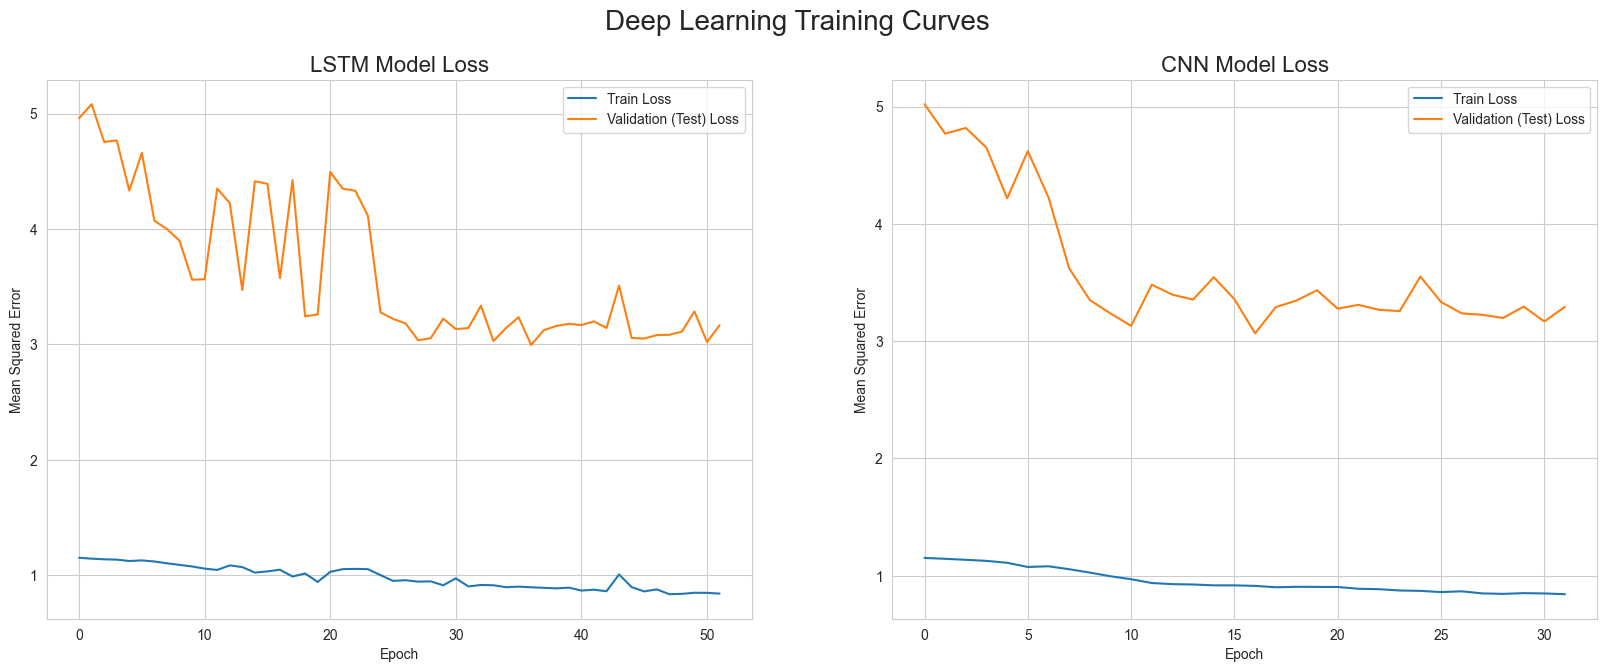

In [48]:
if RUN_MODELS['LSTM'] and RUN_MODELS['CNN']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    ax1.plot(train_losses_lstm, label='Train Loss')
    ax1.plot(val_losses_lstm, label='Validation (Test) Loss')
    ax1.set_title('LSTM Model Loss', fontsize=16)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Squared Error')
    ax1.legend()
    ax2.plot(train_losses_cnn, label='Train Loss')
    ax2.plot(val_losses_cnn, label='Validation (Test) Loss')
    ax2.set_title('CNN Model Loss', fontsize=16)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Squared Error')
    ax2.legend()
    plt.suptitle('Deep Learning Training Curves', fontsize=20)
    plt.savefig("loss_curves.png")
    plt.show()

## 10. Final Evaluation (Corrected)

In [49]:
def reconstruct_yield(y_pred_scaled, df_ref, y_scaler_obj):
    """Inverse transforms a prediction to the original yield scale."""
    if y_pred_scaled.ndim == 1:
        y_pred_scaled = y_pred_scaled.reshape(-1, 1)
    
    y_pred_detrended = y_scaler_obj.inverse_transform(y_pred_scaled)
    
    trend = df_ref['yield_trend'].values.reshape(-1, 1)
    y_pred_actual = y_pred_detrended + trend
    
    return y_pred_actual.flatten()

# --- Evaluation ---
results = []
y_preds_original = {}

print("\n--- Final Performance (Test Set) ---")

for name, model in models.items():
    if name in ['LR', 'RF', 'XGB']:
        # Predict on the scaled test set
        preds_scaled = model.predict(X_test_ml)
        # Reconstruct the predictions
        pred_orig = reconstruct_yield(preds_scaled, test_df, y_scaler)
        y_true_orig = test_df[TARGET].values
        # Store for later use
        y_preds_original[name] = pred_orig
        
    elif name in ['LSTM', 'CNN']:
        model.eval()
        with torch.no_grad():
            # Predict on the scaled test set
            preds_scaled_t = model(*[x.to(device) for x in X_test_dl])
            preds_scaled = preds_scaled_t.cpu().numpy()
            # Reconstruct the predictions
            pred_orig = reconstruct_yield(preds_scaled, test_df_dl_seq_ref, y_scaler)
            y_true_orig = test_df_dl_seq_ref[TARGET].values
            # Store for later use
            y_preds_original[name] = pred_orig

    # Calculate metrics
    mae = mean_absolute_error(y_true_orig, pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, pred_orig))
    map_e = mape(y_true_orig, pred_orig)
    rms_pe = rmspe(y_true_orig, pred_orig)
    r_2 = r2_score(y_true_orig, pred_orig)
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': map_e, 'RMSPE (%)': rms_pe, 'R²': r_2})

results_df = pd.DataFrame(results).set_index('Model').sort_values('RMSPE (%)')
print(results_df.round(2))
results_df.to_csv("final_model_performance.csv")


--- Final Performance (Test Set) ---
           MAE      RMSE  MAPE (%)  RMSPE (%)    R²
Model                                              
LR     6320.93  13765.49     10.25      28.87  0.98
RF     6176.17  14707.11     10.31      30.26  0.98
XGB    6480.51  16168.12     10.94      33.38  0.97
CNN    9617.83  17894.78     13.35      45.98  0.97
LSTM   9766.42  17545.68     13.70      46.78  0.97


## 11. Plot Model Performances

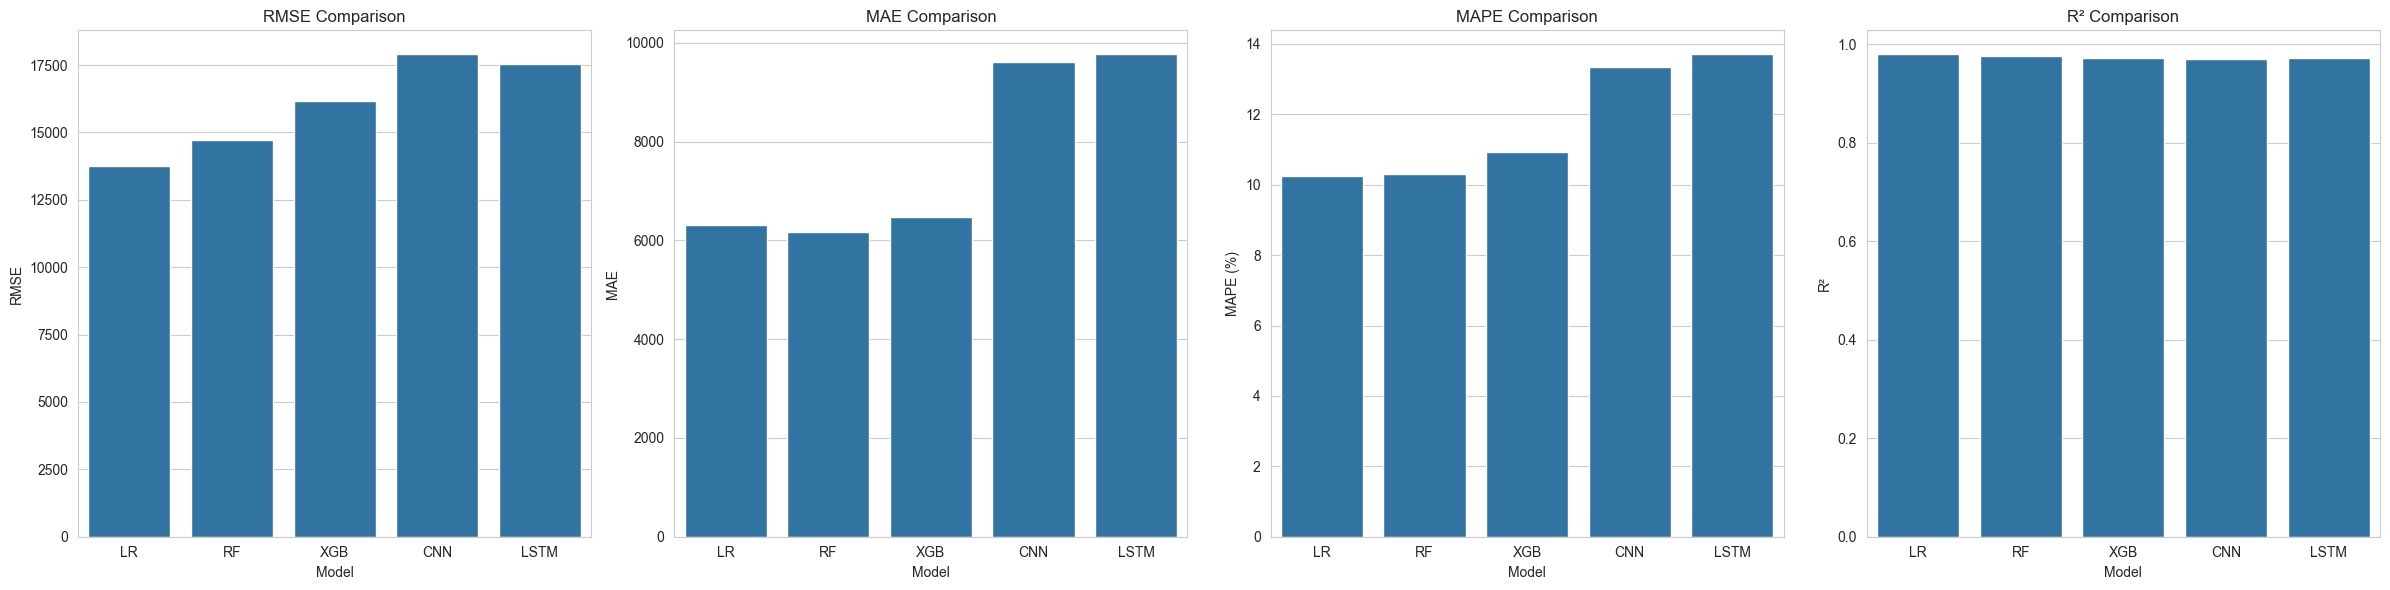

In [50]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
sns.barplot(data=results_df.reset_index(), x='Model', y='RMSE', ax=axs[0])
axs[0].set_title('RMSE Comparison')
sns.barplot(x='Model', y='MAE', data=results_df.reset_index(), ax=axs[1])
axs[1].set_title('MAE Comparison')
sns.barplot(x='Model', y='MAPE (%)', data=results_df.reset_index(), ax=axs[2])
axs[2].set_title('MAPE Comparison')
sns.barplot(x='Model', y='R²', data=results_df.reset_index(), ax=axs[3])
axs[3].set_title('R² Comparison')
plt.tight_layout()
plt.savefig("model_performance_comparison.png")
plt.show()

## 12. Per-Crop Reporting (Best Model)

In [51]:
best_model_name = results_df.index[0]
print(f"Per-crop report for best model: {best_model_name}")
crop_results = []
# Use the correctly aligned test dataframe based on the best model
if best_model_name in ['LR', 'RF', 'XGB']:
    reporting_df = test_df
    y_true_original = reporting_df[TARGET].values
else:
    reporting_df = test_df_dl_seq_ref
    y_true_original = reporting_df[TARGET].values

items = reporting_df['Item'].values

for crop in np.unique(items):
    mask = items == crop
    true = y_true_original[mask]
    pred = y_preds_original[best_model_name][mask]
    if len(true) > 0:
        crop_results.append({
            'Crop': crop,
            'RMSPE (%)': rmspe(true, pred),
            'MAPE (%)': mape(true, pred),
            'RMSE': np.sqrt(mean_squared_error(true, pred)),
            'R²': r2_score(true, pred)
        })
crop_df = pd.DataFrame(crop_results).sort_values('RMSPE (%)')
print(crop_df.round(2))
crop_df.to_csv('per_crop_performance.csv', index=False)

Per-crop report for best model: LR
                   Crop  RMSPE (%)  MAPE (%)      RMSE    R²
7        Sweet potatoes      11.73      7.26  19601.54  0.94
3              Potatoes      12.23      7.10  22178.78  0.95
8                 Wheat      14.91      8.51   4038.31  0.95
1                 Maize      17.43      9.13   7010.21  0.95
4           Rice, paddy      17.84      7.89   5044.25  0.94
9                  Yams      19.97      9.03  15527.71  0.92
0               Cassava      21.30      9.84  19045.36  0.97
6              Soybeans      22.05     10.72   2258.17  0.93
2  Plantains and others      25.55     12.78  29951.18  0.78
5               Sorghum      72.24     23.27   9877.67  0.75


## 13. SHAP Analysis (If Tree Model)

In [52]:
best_model_name = results_df.index[0]
if best_model_name in models and best_model_name in ['RF', 'XGB']:
    best_model = models[best_model_name]
    print(f"Running SHAP on {best_model_name}")
    # For SHAP, we need to use the correctly aligned test features
    X_test_shap = X_test_ml
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_shap)
    shap.summary_plot(shap_values, X_test_shap, plot_type="beeswarm", show=False)
    plt.title(f"SHAP Beeswarm ({best_model_name})", fontsize=16)
    plt.savefig("shap_beeswarm.png", bbox_inches='tight')
    plt.show()
    shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
    plt.title(f"Feature Importance ({best_model_name})", fontsize=16)
    plt.savefig("shap_importance.png", bbox_inches='tight')
    plt.show()
else:
    print("SHAP skipped for non-tree model.")

SHAP skipped for non-tree model.


## 14. Export Predictions

In [53]:
# Create a base dataframe for predictions. ML models have more test samples than DL models.
final_predictions_df = test_df.copy()
final_predictions_df['true_yield_original'] = final_predictions_df[TARGET]

# Add predictions. Note that DL predictions will have NaNs for non-sequenced rows.
for name, preds in y_preds_original.items():
    if name in ['LR', 'RF', 'XGB']:
        final_predictions_df[f'predicted_{name}'] = preds
    else:
        # Align DL predictions with the main test dataframe
        dl_preds_series = pd.Series(preds, index=test_df_dl_seq_ref.index, name=f'predicted_{name}')
        final_predictions_df = final_predictions_df.join(dl_preds_series)

export_cols = ['Year', 'Area', 'Item', 'true_yield_original'] + [f'predicted_{name}' for name in models.keys()]
final_predictions_df[export_cols].to_csv("final_test_predictions.csv", index=False)
print("Exported predictions.")
print("\n--- Complete ---")

Exported predictions.

--- Complete ---
